# Assignment 3: Score Based Generative Modeling Through Stochastic Differential Equations

In this assignment, you will be implementing architectures seen in the paper Scored Based Generative Modeling Through Stochastic Differential Equations, which we saw in the tutorials connects between the two methods you have already implemented. Due to this already being the third assignment, there will be less guidance throughout the exercise and you will have more of a free hand. Remember to turn off machines when you're not using them, and to frequently save checkpoints of your models!

The free hand means that documentation is important. We expect non-trivial functions to be documented. Additionally, we expect (brief) explanations in the notebook of how you chose to implement each part of the assignment. Good luck!

## Submission Guidelines

- If it is more comfortable, you may submit either a python project with several files which define functions or a single python notebook that implements everything. The python notebook should include outputs, even if they are not the same outputs as the ones you submit in the zip.
- If you choose to submit using a python project, you must also submit a notebook that runs all relevant functions and generates all outputs (they don't need to be the same as the ones that are in the visualization zip, but we should be able to see that all functions run correctly). There should be two zips in this case: one containing all code files (including the notebook that replicates the outputs) and another containing the visualizations as done before.
- You may name the zip files as you wish, as long as your ID is in the name.
- All other requirements are based on the requirements in the syllabus.
- Reminder: You can play with the functions as much as you want to, and don't need to implement functions using the same parameters / names as what we provide. All changes that you make should be documented and should still do all the things you're required to do.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

## Part 1: Visualizing SDEs Using Simulations

In this part, we will recreate part of Figure 2 in https://arxiv.org/pdf/2011.13456 using Euler's method for sampling from SDEs. In particular, we will be recreating the Variance Preserving SDE (DDPM's continuous form):

$$
d\textbf{x}_t = -\frac{1}{2}\beta_t \textbf{x}_t dt + \sqrt{\beta_t} d\textbf{w}_t
$$

Note that in the paper, Figure 2 is of the ALD based SDE, so it looks different than what you will be creating. Throughout this part of the assignment, we will be working with $\beta_0 = 0.1, \beta_1 = 20$, $\beta(t) = (\beta_1 - \beta_0)t + \beta_0$. $\mathbf{x}_0$ follows a mixture of Gaussians distribution, with probability 0.5 of being centered around -3 and 0.5 of being centered around 3, with standard deviation 0.5.

This part can be entirely run on your PC, without needing the VM or CUDA. We strongly recommend to run this part of the assignment locally.

1. For $\textbf{x} \in \mathbb{R}$, formulate the ground truth distribution $p_t(\textbf{x}_t | \textbf{x}_0)$ and the function $\nabla_{\textbf{x}_t} \log p_t(\textbf{x}_t | \textbf{x}_0)$. Note $\Sigma_0 = 0$.
2. Train a simple model using the loss from tutorials 5/6 to approximate the marginal score: $\nabla_{\textbf{x}_t}\log p_t(\textbf{x}_t)$, for the above SDE.
3. Sample 100,000 values for $\textbf{x}_0$ following a mixture of Gaussians, probability 0.5 of being centered around -3 and 0.5 being centered around 3, with standard deviation 0.5. Advance them according to the SDE provided in DDPM, using Euler's method with `T=1000` and step size `1e-3`. What is the distribution we reached?
4. For 10,000 random starting points, advance them according to the probability flow ODE, using the score you learned. Note that despite the fact that you need the score to do this, *you are still advancing the points according to the forward process*!
5. Now, reverse the process by sampling 10,000 samples from the prior distribution and taking reverse steps according to the reverse SDE using the score. To sample using Euler in the reverse process, see equation 46 in the paper linked above (in Appendix E, $\mathbf{f}\equiv \mu, \mathbf{G}\equiv \sigma$). Display the trajectory of 2 random starting points using the reverse SDE.
6. Bonus (2 points): Sample 10,000 points according to the reverse probability flow ODE and display the trajectory of two random starting points.

Display the histogram of $\mathbf{x}_t$ as a function of time using a heatmap on the $y$ axis. You can use meshgrids and `matplotlib`'s pcolormesh to display the histogram as shown below. There should be 3/4 total histograms:

1. Histogram of Euler discretization of forward SDE (100,000 starting points).
2. Histogram of Euler discretization of probability flow ODE (10,000 starting points). It's ok if the histogram isn't as nice as the SDE histogram, but points will still be deducted if it's very different in general behavior.
3. Histogram of Euler discretization of reverse SDE (10,000 starting points). It's ok if it isn't exactly the reverse of the forward SDE, but points will still be removed if there are mistakes in the code.
4. (Bonus) Histogram of Euler discretization of reverse probability flow ODE (10,000 starting points).

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# ==================== Diffusion Parameters ====================
BETA_START, BETA_END = 0.1, 20.0

def beta_schedule(t):
    """Linear beta schedule from BETA_START to BETA_END"""
    return BETA_START + (BETA_END - BETA_START) * t

def compute_gamma(t):
    """Compute Γ(t) = exp(-½∫β(s)ds)"""
    return np.exp(-0.5 * (BETA_START * t + 0.5 * (BETA_END - BETA_START) * t**2))

def compute_variance(t, num_points=400):
    """Compute σ²(t) = Γ(t)² ∫₀ᵗ β(s)/Γ(s)² ds using numerical integration"""
    time_points = np.linspace(0., t, num_points + 1)
    integrand = beta_schedule(time_points) / (compute_gamma(time_points) ** 2)
    return (compute_gamma(t) ** 2) * np.trapz(integrand, time_points)

# Vectorize functions for array inputs
vectorized_gamma = np.vectorize(compute_gamma)
vectorized_variance = np.vectorize(compute_variance)

# ==================== Score Network ====================
class ScoreNetwork(nn.Module):
    """Neural network to estimate the score function"""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.SiLU(),
            nn.Linear(64, 64), nn.SiLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

def sample_initial_points(num_samples):
    """Sample from a mixture of two Gaussians centered at ±3"""
    component = np.random.rand(num_samples) < 0.5
    means = np.where(component, 3.0, -3.0)
    return np.random.normal(means, 0.5)

def train_score_model(model, num_steps=3000, batch_size=2048, learning_rate=1e-3):
    """Train the score estimation network"""
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for _ in tqdm(range(num_steps)):
        # Sample data and noise
        x0 = sample_initial_points(batch_size)
        time = np.random.rand(batch_size)
        gamma = vectorized_gamma(time)
        variance = vectorized_variance(time)
        noise = np.random.randn(batch_size)

        # Compute noisy samples and target scores
        xt = gamma * x0 + np.sqrt(variance) * noise
        target_score = -noise / np.sqrt(variance)

        # Convert to tensors
        xt_tensor = torch.from_numpy(xt[:, None]).float().to(device)
        time_tensor = torch.from_numpy(time[:, None]).float().to(device)
        target_tensor = torch.from_numpy(target_score[:, None]).float().to(device)

        # Training step
        loss = ((model(xt_tensor, time_tensor) - target_tensor) ** 2).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return model

# ==================== Simulation Parameters ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_STEPS = 1000
TIME_STEP = 1.0 / NUM_STEPS
X_BINS = np.linspace(-6, 6, 200)
TIME_GRID = np.linspace(0, 1, NUM_STEPS + 1)

# Initialize and train the score model
score_model = train_score_model(ScoreNetwork().to(device))

  0%|          | 0/3000 [00:00<?, ?it/s]<ipython-input-9-a3a6b11ad8d1>:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return (compute_gamma(t) ** 2) * np.trapz(integrand, time_points)
100%|██████████| 3000/3000 [09:04<00:00,  5.51it/s]


<ipython-input-9-a3a6b11ad8d1>:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return (compute_gamma(t) ** 2) * np.trapz(integrand, time_points)


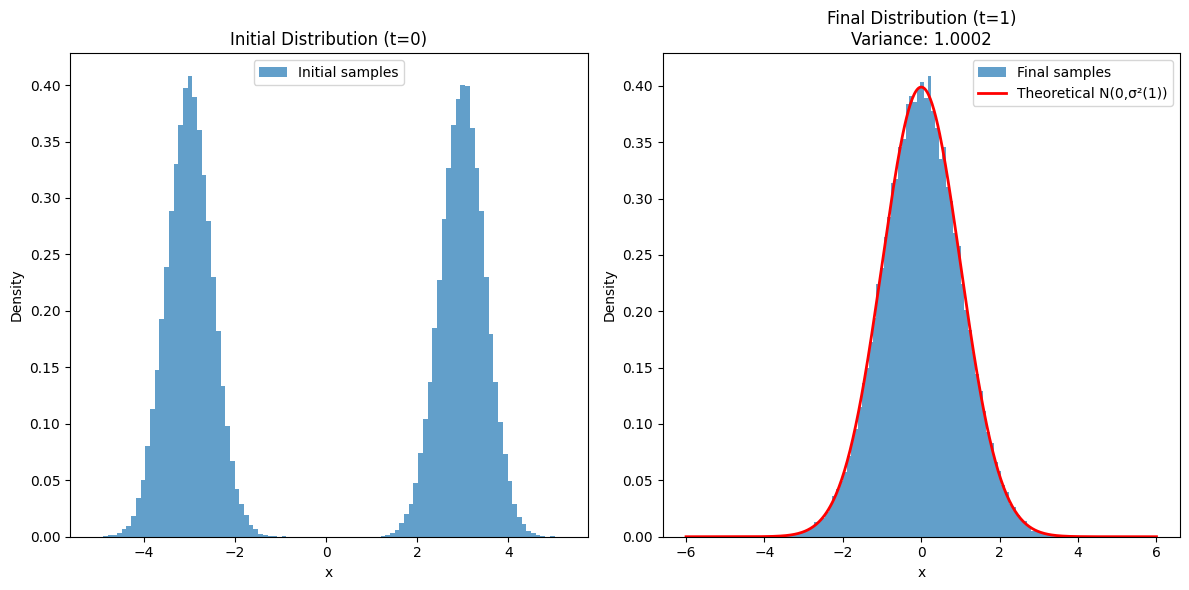

<ipython-input-14-bae0891f59fd>:304: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


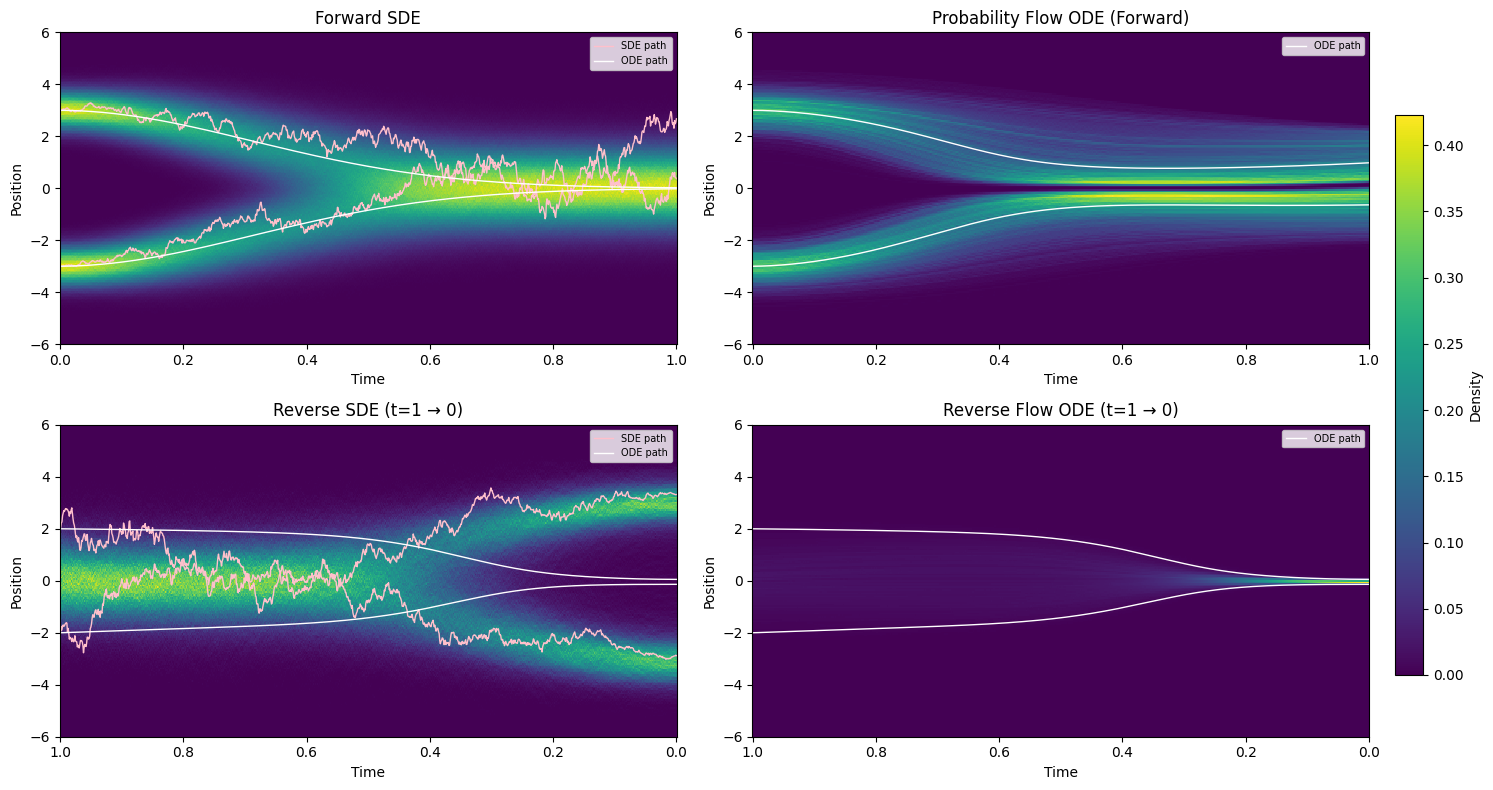

In [ ]:
# ==================== Simulation Functions ====================
def simulate_forward_sde():
    """Simulate forward SDE and analyze final distribution"""
    x_up, x_down = 3.0, -3.0
    trajectory_up = [x_up]
    trajectory_down = [x_down]
    density_history = np.zeros((len(X_BINS)-1, NUM_STEPS+1))

    # Initialize particle cloud
    cloud = sample_initial_points(100000)
    initial_samples = cloud.copy()  # Store initial samples for comparison
    density_history[:, 0], _ = np.histogram(cloud, bins=X_BINS, density=True)

    for step in range(NUM_STEPS):
        current_beta = beta_schedule(step * TIME_STEP)

        # Update particle cloud
        cloud += (-0.5 * current_beta * cloud) * TIME_STEP + \
                np.sqrt(current_beta * TIME_STEP) * np.random.randn(len(cloud))
        density_history[:, step+1], _ = np.histogram(cloud, bins=X_BINS, density=True)

        # Update tracked particles
        x_up += (-0.5 * current_beta * x_up) * TIME_STEP + \
               np.sqrt(current_beta * TIME_STEP) * np.random.randn()
        x_down += (-0.5 * current_beta * x_down) * TIME_STEP + \
                 np.sqrt(current_beta * TIME_STEP) * np.random.randn()
        trajectory_up.append(x_up)
        trajectory_down.append(x_down)

    # ====== Analysis of Final Distribution ======
    plt.figure(figsize=(12, 6))

    # Plot initial distribution
    plt.subplot(1, 2, 1)
    plt.hist(initial_samples, bins=100, density=True, alpha=0.7, label='Initial samples')
    plt.title('Initial Distribution (t=0)')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()

    # Plot final distribution
    plt.subplot(1, 2, 2)
    final_density, bins, _ = plt.hist(cloud, bins=100, density=True, alpha=0.7,
                                    label='Final samples')

    # Plot theoretical terminal distribution (should be N(0, σ²(1)))
    final_variance = compute_variance(1.0)
    x_grid = np.linspace(-6, 6, 500)
    theoretical = np.exp(-0.5*x_grid**2/final_variance)/np.sqrt(2*np.pi*final_variance)
    plt.plot(x_grid, theoretical, 'r-', lw=2, label='Theoretical N(0,σ²(1))')

    plt.title(f'Final Distribution (t=1)\nVariance: {final_variance:.4f}')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return density_history, np.array(trajectory_up), np.array(trajectory_down)


def simulate_forward_ode_samples(num_samples=10000):
    """Simulate forward ODE with learned score for density estimation"""
    xs = sample_initial_points(num_samples)
    density_history = np.zeros((len(X_BINS)-1, NUM_STEPS + 1))
    density_history[:, 0], _ = np.histogram(xs, bins=X_BINS, density=True)

    for step in range(NUM_STEPS):
        mid_time = (step + 0.5) * TIME_STEP
        current_beta = beta_schedule(mid_time)

        # Get score estimate
        x_tensor = torch.from_numpy(xs[:, None]).float().to(device)
        t_tensor = torch.full_like(x_tensor, mid_time)
        with torch.no_grad():
            score = score_model(x_tensor, t_tensor).cpu().numpy().flatten()

        # Update positions
        drift = (-0.5 * current_beta * xs - 0.5 * current_beta * score) * TIME_STEP
        xs += drift

        density_history[:, step + 1], _ = np.histogram(xs, bins=X_BINS, density=True)

    return density_history

def simulate_forward_ode_paths():
    """Simulate forward ODE paths using learned score"""
    x_up, x_down = 3.0, -3.0
    path_up = [x_up]
    path_down = [x_down]

    for step in range(NUM_STEPS):
        mid_time = (step + 0.5) * TIME_STEP
        current_beta = beta_schedule(mid_time)
        x_batch = np.array([x_up, x_down])

        # Get score estimate
        x_tensor = torch.from_numpy(x_batch.reshape(-1,1)).float().to(device)
        t_tensor = torch.full_like(x_tensor, mid_time)
        with torch.no_grad():
            score = score_model(x_tensor, t_tensor).cpu().numpy().flatten()

        # Update positions
        drift = (-0.5 * current_beta * x_batch - 0.5 * current_beta * score) * TIME_STEP
        x_batch += drift

        x_up, x_down = x_batch
        path_up.append(x_up)
        path_down.append(x_down)

    return np.array(path_up), np.array(path_down)

def simulate_reverse_sde_samples(num_samples=10000):
    """Simulate reverse SDE with learned score for density estimation"""
    final_variance = compute_variance(1.0)
    xs = np.random.randn(num_samples) * np.sqrt(final_variance)
    density_history = np.zeros((len(X_BINS)-1, NUM_STEPS + 1))
    density_history[:, -1], _ = np.histogram(xs, bins=X_BINS, density=True)

    for step in reversed(range(NUM_STEPS)):
        current_time = step * TIME_STEP
        current_beta = beta_schedule(current_time)

        # Get score estimate
        x_tensor = torch.from_numpy(xs[:, None]).float().to(device)
        t_tensor = torch.full_like(x_tensor, current_time)
        with torch.no_grad():
            score = score_model(x_tensor, t_tensor).cpu().numpy().flatten()

        # Update positions
        noise = np.random.randn(num_samples)
        xs += (0.5 * current_beta * xs + current_beta * score) * TIME_STEP + np.sqrt(current_beta * TIME_STEP) * noise
        density_history[:, step], _ = np.histogram(xs, bins=X_BINS, density=True)

    return density_history

def simulate_reverse_sde_paths():
    """Simulate reverse SDE paths using learned score"""
    '''final_std = np.sqrt(compute_variance(1.0))
    x_up, x_down = final_std * np.random.randn(2)  # Sample from N(0, σ²(1))'''
    x_up, x_down = 2.0, -2.0
    path_up = [x_up]
    path_down = [x_down]

    for step in reversed(range(NUM_STEPS)):
        current_time = step * TIME_STEP
        current_beta = beta_schedule(current_time)
        x_batch = np.array([x_up, x_down])

        # Get score estimate
        x_tensor = torch.from_numpy(x_batch.reshape(-1,1)).float().to(device)
        t_tensor = torch.full_like(x_tensor, current_time)
        with torch.no_grad():
            score = score_model(x_tensor, t_tensor).cpu().numpy().flatten()

        # Update positions with reverse SDE
        noise = np.random.randn(2)
        x_batch += (0.5 * current_beta * x_batch + current_beta * score) * TIME_STEP + np.sqrt(current_beta * TIME_STEP) * noise
        x_up, x_down = x_batch
        path_up.append(x_up)
        path_down.append(x_down)

    return np.array(path_up[::-1]), np.array(path_down[::-1])

def simulate_reverse_ode_samples(num_samples=10000):
    """Simulate reverse ODE with learned score for density estimation"""
    final_variance = compute_variance(1.0)
    xs = np.random.randn(num_samples) * np.sqrt(final_variance)
    density_history = np.zeros((len(X_BINS)-1, NUM_STEPS + 1))
    density_history[:, -1], _ = np.histogram(xs, bins=X_BINS, density=True)

    for step in reversed(range(NUM_STEPS)):
        mid_time = (step + 0.5) * TIME_STEP
        current_beta = beta_schedule(mid_time)

        # Get score estimate
        x_tensor = torch.from_numpy(xs[:, None]).float().to(device)
        t_tensor = torch.full_like(x_tensor, mid_time)
        with torch.no_grad():
            score = score_model(x_tensor, t_tensor).cpu().numpy().flatten()

        # Update positions
        xs += (0.5 * current_beta * xs + 0.5 * current_beta * score) * (-TIME_STEP)
        density_history[:, step], _ = np.histogram(xs, bins=X_BINS, density=True)

    return density_history

def simulate_reverse_ode_paths():
    """Simulate reverse ODE paths using learned score"""
    '''final_std = np.sqrt(compute_variance(1.0))
    x_up, x_down = final_std * np.random.randn(2)  # Sample from N(0, σ²(1))'''
    x_up, x_down = 2.0, -2.0
    path_up = [x_up]
    path_down = [x_down]

    for step in reversed(range(NUM_STEPS)):
        mid_time = (step + 0.5) * TIME_STEP
        current_beta = beta_schedule(mid_time)
        x_batch = np.array([x_up, x_down])

        # Get score estimate
        x_tensor = torch.from_numpy(x_batch.reshape(-1,1)).float().to(device)
        t_tensor = torch.full_like(x_tensor, mid_time)
        with torch.no_grad():
            score = score_model(x_tensor, t_tensor).cpu().numpy().flatten()

        # Update positions with reverse ODE
        x_batch += (0.5 * current_beta * x_batch + 0.5 * current_beta * score) * (-TIME_STEP)
        x_up, x_down = x_batch
        path_up.append(x_up)
        path_down.append(x_down)

    return np.array(path_up[::-1]), np.array(path_down[::-1])

# ==================== Run Simulations ====================
# Forward processes
fwd_sde_density, fwd_sde_up, fwd_sde_down = simulate_forward_sde()
fwd_ode_density = simulate_forward_ode_samples()
fwd_ode_up, fwd_ode_down = simulate_forward_ode_paths()

# Reverse processes
rev_sde_density = simulate_reverse_sde_samples()
rev_sde_up, rev_sde_down = simulate_reverse_sde_paths()
rev_ode_density = simulate_reverse_ode_samples()
rev_ode_up, rev_ode_down = simulate_reverse_ode_paths()

# Analytical ODE paths
analytical_up = vectorized_gamma(TIME_GRID) * 3.0
analytical_down = vectorized_gamma(TIME_GRID) * -3.0

# ==================== Plotting ====================

def plot_density_with_paths(ax, density, sde_path_up, sde_path_down, ode_path_up, ode_path_down, title, invert_time=False):
    """Helper function to plot density heatmap with trajectories"""
    time_grid, x_grid = np.meshgrid(TIME_GRID, 0.5 * (X_BINS[1:] + X_BINS[:-1]))
    pcm = ax.pcolormesh(time_grid, x_grid, density, shading='auto')

    if sde_path_up is not None:
        ax.plot(TIME_GRID, sde_path_up, lw=1.0, color='pink', label='SDE path')
        ax.plot(TIME_GRID, sde_path_down, lw=1.0, color='pink')

    ax.plot(TIME_GRID, ode_path_up, lw=1.0, color='white', label='ODE path')
    ax.plot(TIME_GRID, ode_path_down, lw=1.0, color='white')

    ax.set_xlabel('Time')
    ax.set_ylabel('Position')
    ax.set_title(title)
    ax.legend(loc='upper right', fontsize=7)

    if invert_time:
        ax.invert_xaxis()  # Flip time axis from 1 → 0 (left → right)

    return pcm


# Create figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# 1. Forward SDE
pcm = plot_density_with_paths(
    axs[0, 0],
    fwd_sde_density,
    fwd_sde_up, fwd_sde_down,
    analytical_up, analytical_down,
    'Forward SDE'
)

# 2. Forward ODE (probability-flow)
plot_density_with_paths(
    axs[0, 1],
    fwd_ode_density,
    None, None,
    fwd_ode_up, fwd_ode_down,
    'Probability Flow ODE (Forward)'
)

# 3. Reverse SDE (time reversed)
plot_density_with_paths(
    axs[1, 0],
    rev_sde_density,
    rev_sde_up, rev_sde_down,
    rev_ode_up, rev_ode_down,
    'Reverse SDE (t=1 → 0)',
    invert_time=True
)

# 4. Reverse ODE (time reversed)
plot_density_with_paths(
    axs[1, 1],
    rev_ode_density,
    None, None,
    rev_ode_up, rev_ode_down,
    'Reverse Flow ODE (t=1 → 0)',
    invert_time=True
)


# Add colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cbar_ax, label='Density')

plt.tight_layout()
plt.show()

The final distribution we reached is Standard Normal (top right histogram).

## Part 2: Implementing DDPM as a Score Network

This part (and all following parts) will require a GPU, so you should run it on the machines we provided.

Note that parts 2 and 3 should heavily rely on your existing DDPM code. Not much has to change.

In the recent tutorials, we showed how the training procedures for DDPM and ALD are actually equivalent, and that using a basic transformation, we can view a model trained according to the DDPM loss as a model that approximates the score. In this part we will show how this is true.
1. Train a DDPM model the same way you trained in HW2, using either MNIST from HW1 (recommended) or Fashion MNIST from HW2. The only difference should be that time ($t$) should be between 0 and 1 as opposed to 1 and $T$. Note that because the time is now of a different scale, we may need to use a different method for time encoding. For now, $\beta(t) = \beta_{t*T}$.
2. Fill in the function ```get_score_model``` that accepts a model that was trained according to the DDPM loss and returns a new model that approximates the score (note that this is a nested function, meaning it returns a function).
3. Sample from the model using the score model, using what we saw in tutorials 5/6 and the sampling method above, or using Ancestral Sampling (shown in Equation 4 in the paper linked in part 1 and in tutorial 4). Display 64 sampled images.

In [ ]:
# ======================= 1. Dependencies ==========================
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm

# Setup device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def beta_schedule_linear(num_steps, beta_start=1e-4, beta_end=2e-2):
    """Returns a linearly spaced beta schedule."""
    return torch.linspace(beta_start, beta_end, num_steps, dtype=torch.float32)

In [ ]:
class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, t):
        half_dim = self.embedding_dim // 2
        scale = math.log(10000) / (half_dim - 1)
        exponents = torch.exp(torch.arange(half_dim, device=t.device) * -scale)
        scaled_time = t[:, None] * exponents[None, :]
        return torch.cat([scaled_time.sin(), scaled_time.cos()], dim=-1)

In [ ]:
# UNet parts
class ResidualBlock(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x, *args, **kwargs):
        return self.func(x, *args, **kwargs) + x

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=None, groups=8):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        ) if time_emb_dim else None

        self.block1 = nn.Sequential(
            nn.GroupNorm(groups, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, 3, padding=1)
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(groups, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )
        self.skip_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)
        if self.time_mlp and time_emb is not None:
            h = h + self.time_mlp(time_emb)[:, :, None, None]
        h = self.block2(h)
        return h + self.skip_conv(x)

class LinearSelfAttention(nn.Module):
    def __init__(self, channels, heads=4, head_dim=32):
        super().__init__()
        self.heads = heads
        inner_dim = heads * head_dim
        self.to_qkv = nn.Conv2d(channels, inner_dim * 3, 1, bias=False)
        self.output_conv = nn.Conv2d(inner_dim, channels, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        q, k, v = self.to_qkv(x).chunk(3, dim=1)
        q = q.reshape(b, self.heads, -1, h * w).softmax(dim=-2)
        k = k.reshape(b, self.heads, -1, h * w).softmax(dim=-1)
        v = v.reshape(b, self.heads, -1, h * w)
        context = torch.einsum('bhnd,bhmd->bhnm', k, v)
        out = torch.einsum('bhnm,bhnd->bhmd', context, q).reshape(b, -1, h, w)
        return self.output_conv(out)

class Down(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class Up(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(channels, channels, 4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
# Full UNet
class DenoisingUNet(nn.Module):
    def __init__(self, base_dim=64, dim_multipliers=(1, 2, 4), in_channels=1, time_embed=True, T=1000):
        super().__init__()
        self.in_channels = in_channels
        self.time_embed_dim = base_dim * 4 if time_embed else None

        self.time_mlp = nn.Sequential(
            TimeEmbedding(base_dim),
            nn.Linear(base_dim, self.time_embed_dim),
            nn.SiLU(),
            nn.Linear(self.time_embed_dim, self.time_embed_dim)
        ) if time_embed else None

        self.init_conv = nn.Conv2d(in_channels, base_dim, kernel_size=7, padding=3)

        dims = [base_dim, *[base_dim * m for m in dim_multipliers]]
        self.enc_blocks = nn.ModuleList()
        for idx, (d_in, d_out) in enumerate(zip(dims[:-1], dims[1:])):
            self.enc_blocks.append(nn.ModuleList([
                ResBlock(d_in, d_out, time_emb_dim=self.time_embed_dim),
                ResBlock(d_out, d_out, time_emb_dim=self.time_embed_dim),
                LinearSelfAttention(d_out) if d_out >= 128 else nn.Identity(),
                Down(d_out) if idx < len(dims) - 2 else nn.Identity()
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = ResBlock(mid_dim, mid_dim, time_emb_dim=self.time_embed_dim)
        self.mid_attn = LinearSelfAttention(mid_dim)
        self.mid_block2 = ResBlock(mid_dim, mid_dim, time_emb_dim=self.time_embed_dim)

        self.dec_blocks = nn.ModuleList()
        for idx, (d_in, d_out) in enumerate(reversed(list(zip(dims[:-1], dims[1:])))):
            self.dec_blocks.append(nn.ModuleList([
                ResBlock(d_out * 2, d_in, time_emb_dim=self.time_embed_dim),
                ResBlock(d_in, d_in, time_emb_dim=self.time_embed_dim),
                LinearSelfAttention(d_in) if d_in >= 128 else nn.Identity(),
                Up(d_in) if idx < len(dims) - 2 else nn.Identity()
            ]))

        self.out_block = ResBlock(base_dim, base_dim, time_emb_dim=self.time_embed_dim)
        self.final_conv = nn.Conv2d(base_dim, in_channels, kernel_size=1)

    def forward(self, x, t):
        time_emb = self.time_mlp(t) if self.time_mlp else None
        x = self.init_conv(x)
        skip_connections = []

        for block1, block2, attn, down in self.enc_blocks:
            x = block1(x, time_emb)
            x = block2(x, time_emb)
            x = attn(x)
            skip_connections.append(x)
            x = down(x)

        x = self.mid_block1(x, time_emb)
        x = self.mid_attn(x)
        x = self.mid_block2(x, time_emb)

        for block1, block2, attn, up in self.dec_blocks:
            x = torch.cat((x, skip_connections.pop()), dim=1)
            x = block1(x, time_emb)
            x = block2(x, time_emb)
            x = attn(x)
            x = up(x)

        x = self.out_block(x, time_emb)
        return self.final_conv(x)

In [ ]:
# Diffusion Scheduler
class NoiseScheduler:
    def __init__(self, num_steps=1000, beta_start=1e-4, beta_end=2e-2, device=DEVICE):
        self.betas = beta_schedule_linear(num_steps, beta_start, beta_end).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_sqrt = torch.sqrt(self.alphas)
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.alpha_bar_sqrt = torch.sqrt(self.alpha_bar)
        self.one_minus_alpha_bar_sqrt = torch.sqrt(1.0 - self.alpha_bar)

    def diffuse(self, x0, step, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        return (
            self.alpha_bar_sqrt[step][:, None, None, None] * x0 +
            self.one_minus_alpha_bar_sqrt[step][:, None, None, None] * noise,
            noise
        )



In [ ]:
def train_model(model, scheduler, dataloader, epochs=30, lr=2e-4, device=DEVICE):
    model.to(device).train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0.0
        for batch, _ in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}"):
            batch = batch.to(device)
            batch_size = batch.size(0)
            steps = torch.randint(0, scheduler.betas.size(0), (batch_size,), device=device)
            time_vals = steps.float() / (scheduler.betas.size(0) - 1)

            noisy_imgs, noise = scheduler.diffuse(batch, steps)
            pred_noise = model(noisy_imgs, time_vals)

            loss = criterion(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}: Avg Loss = {total_loss / len(dataloader):.4f}")

In [ ]:
# ==================== 8. Dataset and Training Setup ====================
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)  # scale (0,1) -> (-1,1)
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform_pipeline)
mnist_loader = DataLoader(mnist_data, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

# Initialize model and schedule
TIME_STEPS = 1000
scheduler = NoiseScheduler(num_steps=TIME_STEPS, device=DEVICE)
unet_model = DenoisingUNet(base_dim=64, dim_multipliers=(1, 2, 4), in_channels=1).to(DEVICE)

In [ ]:
train_model(unet_model, scheduler, mnist_loader, epochs=35, lr=1e-4, device=DEVICE)

In [ ]:
# Save the entire model (architecture + weights)
def save_model(model, path="ddpm_unet.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Save trained UNet model
save_model(unet_model, path="ddpm_unet.pth")

In [ ]:
# Initialize model architecture
model = DenoisingUNet(base_dim=64, dim_multipliers=(1, 2, 4), in_channels=1)
model.load_state_dict(torch.load("ddpm_unet.pth"))
model.to(DEVICE)
model.eval()

In [ ]:
def wrap_as_score_fn(eps_predictor, sigma_schedule):
    eps_predictor.eval()

    @torch.no_grad()
    def score_fn(x_t, t_cont):
        if t_cont.dim() == 0:
            t_cont = t_cont[None]

        t_cont = t_cont.to(dtype=torch.float32, device=x_t.device)
        T = len(sigma_schedule)
        indices = (t_cont * (T - 1)).round().long()

        sigma_t = sigma_schedule[indices].to(x_t.device).view(-1, 1, 1, 1)
        eps_hat = eps_predictor(x_t, t_cont)

        return -eps_hat / sigma_t

    return score_fn

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

@torch.no_grad()
def sample_via_ancestral(score_function, beta_schedule, alpha_schedule, alpha_bar_schedule,
                         num_steps=1000, batch_size=64, image_size=28, num_channels=1, device="cuda"):
    """
    Perform ancestral sampling as described in DDPM (Equation 4):

        x_{t-1} = (x_t + β_t ∇_x log p_t(x_t)) / sqrt(α_t) + sqrt(β_t) * z

    Parameters
    ----------
    score_function : callable
        Function that returns ∇_x log p_t(x_t) given (x_t, t).
    beta_schedule : torch.Tensor
        β_t values, shape (T,)
    alpha_schedule : torch.Tensor
        α_t values, shape (T,)
    alpha_bar_schedule : torch.Tensor
        Not used here but included for API symmetry.
    num_steps : int
        Total number of diffusion steps (T).
    batch_size : int
        Number of images to sample.
    image_size : int
        Height and width of the square images.
    num_channels : int
        Number of channels (e.g., 1 for grayscale).
    device : str
        Device to run the sampling on.

    Returns
    -------
    x : torch.Tensor
        Sampled images of shape (batch_size, num_channels, image_size, image_size)
    """
    # Initialize with standard Gaussian noise
    x = torch.randn(batch_size, num_channels, image_size, image_size, device=device)

    for step in reversed(range(num_steps)):
        t = torch.full((batch_size,), step / (num_steps - 1), device=device)
        grad_log_prob = score_function(x, t)

        beta_t = beta_schedule[step]
        alpha_t = alpha_schedule[step]

        # Reverse update equation
        x = (x + beta_t * grad_log_prob) / torch.sqrt(alpha_t)

        # Add noise except at final step
        if step > 0:
            noise = torch.randn_like(x)
            x = x + torch.sqrt(beta_t) * noise

    return x


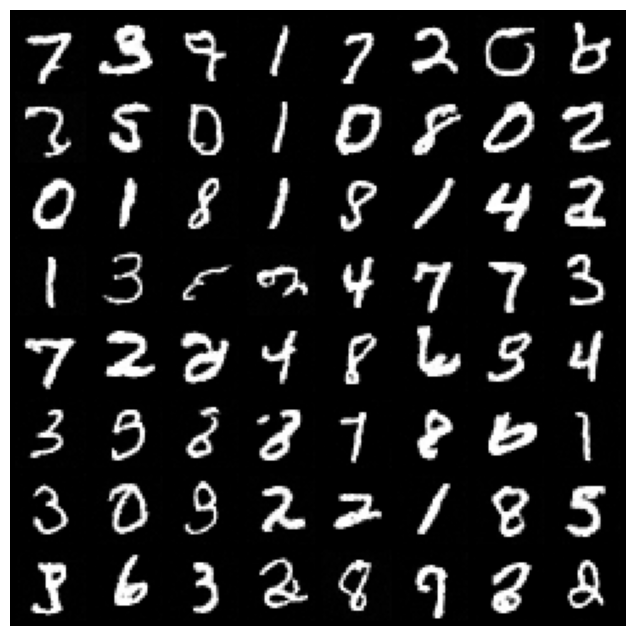

In [ ]:
# 1. Wrap trained epsilon network into score function
score_estimator = wrap_as_score_fn(
    eps_predictor=unet_model,
    sigma_schedule=scheduler.one_minus_alpha_bar_sqrt
)

# 2. Generate samples using ancestral sampling
generated_images = sample_via_ancestral(
    score_function=score_estimator,
    beta_schedule=scheduler.betas,
    alpha_schedule=scheduler.alphas,
    alpha_bar_schedule=scheduler.alpha_bar,
    num_steps=1000,
    batch_size=64,
    image_size=28,
    num_channels=1,
    device=DEVICE
)

# 3. Display generated samples in a grid
generated_images = (generated_images.clamp(-1, 1) + 1) / 2  # map from [-1,1] to [0,1]
image_grid = make_grid(generated_images, nrow=8)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(image_grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
plt.show()


## Part 3: True SDE Implementation

In the previous part, we still used the $\alpha_t$ notations. Now, we will get rid of them and instead implement a true SDE based model, based on the DDPM SDE (variance preserving). We assume a linear $\beta_t$ schedule like before, meaning that the integral to compute the conditional mean can be computed. Remember that now the continuous transformation of $\beta_t$ is $\beta(t)=T\beta_i$ for $i=Tt$. Tip: remember that the continuous version's means should be similar to $\alpha_i$ in the discrete case.

1. Fill in the classes `DDPM_SDE`, `UnifiedLoss`. For the loss, you can either use the score matching loss (less recommended) or the regular noise matching loss. If you use the noise matching loss, implement a function `get_score_model_continuous(model, sde)` that transforms your model that approximates noise to a model that approximates the score. Remember that for $t=0$, we may have a problem defining the std=0, so we can define a small std instead. Implement `train_sde`.
2. Fill in the class `AncestralSamplingContinuous`. This class can either sample using what we saw in part 2 or using Euler's method on the reverse DDPM SDE as implemented in part 1. Implement `sample_images` which should denoise images. Note that the final sampling step should add 0 noise.

Again, note that not much has to change in this part, except now $\beta$ should be implemented as a function and not a sequence, $\alpha_t$ is replaced with the calculation from the tutorial.

Example output:

![image.png](attachment:image.png)

In [2]:
# ----- The models like in the HW2 ------


# Temporal Encoding via Sinusoids
class SinusoidalPositionEmbeddings(nn.Module):
    """Generates fixed sinusoidal embeddings for temporal conditioning."""
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim

    def forward(self, time):
        half_dim = self.emb_dim // 2
        factor = math.log(10000) / (half_dim - 1)
        exponents = torch.exp(torch.arange(half_dim, device=time.device) * -factor)
        angles = time[:, None] * exponents[None, :]
        return torch.cat([angles.sin(), angles.cos()], dim=-1)

# UNet building blocks
class Residual(nn.Module):
    def __init__(self, layer_fn):
        super().__init__()
        self.layer_fn = layer_fn

    def forward(self, x, *args, **kwargs):
        return self.layer_fn(x, *args, **kwargs) + x

class ResnetBlock(nn.Module):
    def __init__(self, in_feat, out_feat, *, time_emb_dim=None, norm_groups=8):
        super().__init__()
        self.time_proj = (nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_feat)
        ) if time_emb_dim is not None else None)

        self.layer1 = nn.Sequential(
            nn.GroupNorm(norm_groups, in_feat),
            nn.SiLU(),
            nn.Conv2d(in_feat, out_feat, kernel_size=3, padding=1)
        )
        self.layer2 = nn.Sequential(
            nn.GroupNorm(norm_groups, out_feat),
            nn.SiLU(),
            nn.Conv2d(out_feat, out_feat, kernel_size=3, padding=1)
        )
        self.skip_connection = nn.Conv2d(in_feat, out_feat, 1) if in_feat != out_feat else nn.Identity()

    def forward(self, x, t_emb=None):
        h = self.layer1(x)
        if self.time_proj is not None and t_emb is not None:
            h = h + self.time_proj(t_emb)[:, :, None, None]
        h = self.layer2(h)
        return h + self.skip_connection(x)

class LinearAttention(nn.Module):
    def __init__(self, input_dim, heads=4, head_dim=32):
        super().__init__()
        self.num_heads = heads
        proj_dim = heads * head_dim
        self.qkv_proj = nn.Conv2d(input_dim, proj_dim * 3, kernel_size=1, bias=False)
        self.output_proj = nn.Conv2d(proj_dim, input_dim, kernel_size=1)

    def forward(self, x):
        b, c, h, w = x.shape
        q, k, v = self.qkv_proj(x).chunk(3, dim=1)
        q = q.view(b, self.num_heads, -1, h * w).softmax(dim=-2)
        k = k.view(b, self.num_heads, -1, h * w).softmax(dim=-1)
        v = v.view(b, self.num_heads, -1, h * w)

        context = torch.einsum('bhnd,bhmd->bhnm', k, v)
        attn_output = torch.einsum('bhnm,bhnd->bhmd', context, q)
        attn_output = attn_output.view(b, -1, h, w)
        return self.output_proj(attn_output)

class Downsample(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.down_conv = nn.Conv2d(input_dim, input_dim, 3, stride=2, padding=1)

    def forward(self, x):
        return self.down_conv(x)

class Upsample(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.up_conv = nn.ConvTranspose2d(input_dim, input_dim, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        return self.up_conv(x)

# Full UNet Model with Temporal Conditioning
class Unet(nn.Module):
    def __init__(self, base_dim=64, init_ch=None, final_ch=None,
                 mult_factors=(1, 2, 4, 8), in_channels=1,
                 use_time_emb=True, norm_groups=8, T=1000):
        super().__init__()
        self.in_channels = in_channels
        init_ch = init_ch or base_dim
        final_ch = final_ch or in_channels
        time_emb_channels = base_dim * 4 if use_time_emb else None

        # Temporal embedding network
        self.time_encoder = (nn.Sequential(
            SinusoidalPositionEmbeddings(base_dim),
            nn.Linear(base_dim, time_emb_channels),
            nn.SiLU(),
            nn.Linear(time_emb_channels, time_emb_channels)
        ) if use_time_emb else None)

        # Initial projection
        self.entry_conv = nn.Conv2d(in_channels, init_ch, 7, padding=3)

        # Downward path
        channels = [init_ch, *[base_dim * m for m in mult_factors]]
        down_pairs = list(zip(channels[:-1], channels[1:]))
        self.encoder = nn.ModuleList()
        for idx, (src, dst) in enumerate(down_pairs):
            self.encoder.append(nn.ModuleList([
                ResnetBlock(src, dst, time_emb_dim=time_emb_channels, norm_groups=norm_groups),
                ResnetBlock(dst, dst, time_emb_dim=time_emb_channels, norm_groups=norm_groups),
                LinearAttention(dst) if dst >= 128 else nn.Identity(),
                Downsample(dst) if idx < len(down_pairs) - 1 else nn.Identity()
            ]))

        # Bottleneck
        mid = channels[-1]
        self.bridge1 = ResnetBlock(mid, mid, time_emb_dim=time_emb_channels)
        self.bridge_attn = LinearAttention(mid)
        self.bridge2 = ResnetBlock(mid, mid, time_emb_dim=time_emb_channels)

        # Upward path
        self.decoder = nn.ModuleList()
        for idx, (src, dst) in enumerate(reversed(down_pairs)):
            self.decoder.append(nn.ModuleList([
                ResnetBlock(dst * 2, src, time_emb_dim=time_emb_channels, norm_groups=norm_groups),
                ResnetBlock(src, src, time_emb_dim=time_emb_channels, norm_groups=norm_groups),
                LinearAttention(src) if src >= 128 else nn.Identity(),
                Upsample(src) if idx < len(down_pairs) - 1 else nn.Identity()
            ]))

        # Output projection
        self.out_block = ResnetBlock(base_dim, base_dim, time_emb_dim=time_emb_channels, norm_groups=norm_groups)
        self.out_conv = nn.Conv2d(base_dim, final_ch, 1)

    def forward(self, x, t):
        time_emb = self.time_encoder(t) if self.time_encoder is not None else None
        x = self.entry_conv(x)
        skip_stack = []

        for block1, block2, attention, down in self.encoder:
            x = block1(x, time_emb)
            x = block2(x, time_emb)
            x = attention(x)
            skip_stack.append(x)
            x = down(x)

        x = self.bridge1(x, time_emb)
        x = self.bridge_attn(x)
        x = self.bridge2(x, time_emb)

        for block1, block2, attention, up in self.decoder:
            skip = skip_stack.pop()
            x = torch.cat([x, skip], dim=1)
            x = block1(x, time_emb)
            x = block2(x, time_emb)
            x = attention(x)
            x = up(x)

        x = self.out_block(x, time_emb)
        return self.out_conv(x)



In [3]:
import math, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# DDPM_SDE: Variance Preserving SDE

class DDPM_SDE:
    """
    Continuous-time version of DDPM using a linear beta schedule.
    Implements drift and diffusion for the VP-SDE.
    """
    def __init__(self, beta_0=1e-4, beta_1=2e-2, T=1000, device=device):
        self.beta_0, self.beta_1, self.T = beta_0, beta_1, T
        self.device = device

    def beta(self, t: torch.Tensor) -> torch.Tensor:
        """Linear beta schedule scaled by T"""
        return self.T * (self.beta_0 + t * (self.beta_1 - self.beta_0))

    def _int_beta(self, t: torch.Tensor) -> torch.Tensor:
        """Integral of beta(t) over [0, t]"""
        return self.T * (self.beta_0 * t + 0.5 * (self.beta_1 - self.beta_0) * t**2)

    def distribution(self, x0: torch.Tensor, t: torch.Tensor):
        """
        Compute mean and std of q(x_t | x_0) using closed-form expression.
        Used for forward noising and training.
        """
        int_beta = self._int_beta(t).to(x0.device)
        alpha_bar = torch.exp(-int_beta)
        mean = (alpha_bar.sqrt())[:, None, None, None] * x0
        std  = (1 - alpha_bar).sqrt()[:, None, None, None]
        return mean, std

    def drift_diffusion(self, x_t: torch.Tensor, t: torch.Tensor):
        """
        Forward SDE drift and diffusion.
        Used in training and reverse-time definition.
        """
        beta_t = self.beta(t)[:, None, None, None]
        drift = -0.5 * beta_t * x_t
        diffusion = beta_t.sqrt()
        return drift, diffusion

    def reverse_drift_diffusion(self, score_fn, x_t, t):
        """
        Compute reverse-time SDE using score function.
        """
        f, g = self.drift_diffusion(x_t, t)
        beta_t = self.beta(t)[:, None, None, None]
        drift_rev = f - beta_t * score_fn(x_t, t)
        diffusion = g
        return drift_rev, diffusion


# Loss: Unified MSE on Noise Prediction

class UnifiedLoss(nn.Module):
    """
    Training loss for noise prediction: predict ε from x_t and t.
    """
    def __init__(self, sde: DDPM_SDE, model: nn.Module):
        super().__init__()
        self.sde = sde
        self.model = model
        self.mse = nn.MSELoss()

    def forward(self, x0: torch.Tensor):
        B = x0.size(0)
        t = torch.rand(B, device=x0.device)  # Sample t ∈ [0,1]
        mean, std = self.sde.distribution(x0, t)  # Forward q(x_t | x_0)
        eps = torch.randn_like(x0)  # True noise
        x_t = mean + std * eps  # Noised input
        eps_hat = self.model(x_t, t)  # Predicted noise
        return self.mse(eps_hat, eps)  # MSE between true and predicted noise


# Score Function Wrapper

def get_score_model_continuous(model: nn.Module, sde: DDPM_SDE, eps: float = 1e-5):
    """
    Turn a noise prediction model into a score function ∇ log p_t(x).
    """
    model.eval()

    @torch.no_grad()
    def score_fn(x_t: torch.Tensor, t: torch.Tensor):
        _, std = sde.distribution(torch.zeros_like(x_t), t)
        std = std.clamp(min=eps)
        eps_hat = model(x_t, t)
        return -eps_hat / std  # Score estimate
    return score_fn


# 5. Reverse-Time Sampler (Euler–Maruyama)

class AncestralSamplingContinuous(nn.Module):
    """
    Euler–Maruyama sampler for the reverse SDE from Gaussian noise.
    """
    def __init__(self, sde: DDPM_SDE, model: nn.Module):
        super().__init__()
        self.sde = sde
        self.T = sde.T
        self.score_fn = get_score_model_continuous(model, sde)

    @torch.no_grad()
    def forward(self, x_init: torch.Tensor):
        x = x_init.to(self.sde.device)
        imgs = []
        dt = 1.0 / self.T
        sqrt_dt = math.sqrt(dt)

        for i in reversed(range(self.T + 1)):
            t_val = i / self.T
            t = torch.full((x.size(0),), t_val, device=x.device)

            drift, diff = self.sde.reverse_drift_diffusion(self.score_fn, x, t)

            if i > 0:
                z = torch.randn_like(x)
                x = x + drift * (-dt) + diff * sqrt_dt * z  # Euler step with noise
            else:
                pass  # take the last x for robustness as recommended in forums, no noise indeed as required in guidelines

            if i % 100 == 0:
                imgs.append(x.clone().cpu())  # Save intermediate result

        return imgs


# 6. Sampling Visualization

def sample_images(model_path: str, sde: DDPM_SDE):
    """
    Load model and visualize 11 steps of denoising for 4 samples.
    """
    # Instantiate the UNet model with correct parameter names
    model = Unet(
        base_dim=64,
        mult_factors=(1, 2, 4),
        in_channels=1,
        final_ch=1
    ).to(device)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    sampler = AncestralSamplingContinuous(sde, model).to(device)
    noise = torch.randn(4, 1, 28, 28, device=device)  # Initial Gaussian noise
    traj = sampler(noise)

    imgs = torch.stack(traj, 1)  # Shape: (B, T+1, C, H, W)
    flat = imgs.reshape(-1, 1, 28, 28)  # Flatten for grid
    grid = make_grid(flat, nrow=11, normalize=True, value_range=(-1, 1))

    plt.figure(figsize=(22, 8))
    plt.title("Denoising – 4x11 grid as output example", fontsize=14)
    plt.imshow(grid.permute(1, 2, 0), cmap="gray")
    plt.axis("off")
    plt.show()


# 7. Dataset Loader (MNIST)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)  # Normalize to [-1, 1]
])
ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(ds, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)


# 8. Training Loop

def train_sde(
    model: nn.Module,
    sde: DDPM_SDE,
    dataloader: DataLoader,
    epochs: int = 30,
    lr: float = 2e-4,
    save_every: int = 1,
    save_prefix: str = "vp_sde"
):
    """
    Training loop for score-based diffusion model using UnifiedLoss.
    Saves checkpoints and visualizations every 'save_every' epochs.
    """
    model.to(device).train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = UnifiedLoss(sde, model)

    for ep in range(epochs):
        running = 0.0
        for x, _ in tqdm(dataloader, desc=f"Epoch {ep+1}/{epochs}"):
            x = x.to(device)
            loss = loss_fn(x)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running += loss.item()

        avg_loss = running / len(dataloader)
        print(f"Epoch {ep+1}: avg loss = {avg_loss:.4f}")

        if (ep + 1) % save_every == 0:
            path = f"{save_prefix}_ep{ep+1}.pth"
            torch.save(model.state_dict(), path)
            print(f"Checkpoint saved at {path}")
            sample_images(model_path=path, sde=sde)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.11MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.47MB/s]


Epoch 1/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: avg loss = 0.1038


Epoch 2/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: avg loss = 0.0472


Epoch 3/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: avg loss = 0.0394


Epoch 4/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: avg loss = 0.0359


Epoch 5/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: avg loss = 0.0339


Epoch 6/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: avg loss = 0.0319


Epoch 7/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: avg loss = 0.0309


Epoch 8/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: avg loss = 0.0297


Epoch 9/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: avg loss = 0.0291


Epoch 10/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: avg loss = 0.0282
Checkpoint saved at vp_sde_ep10.pth


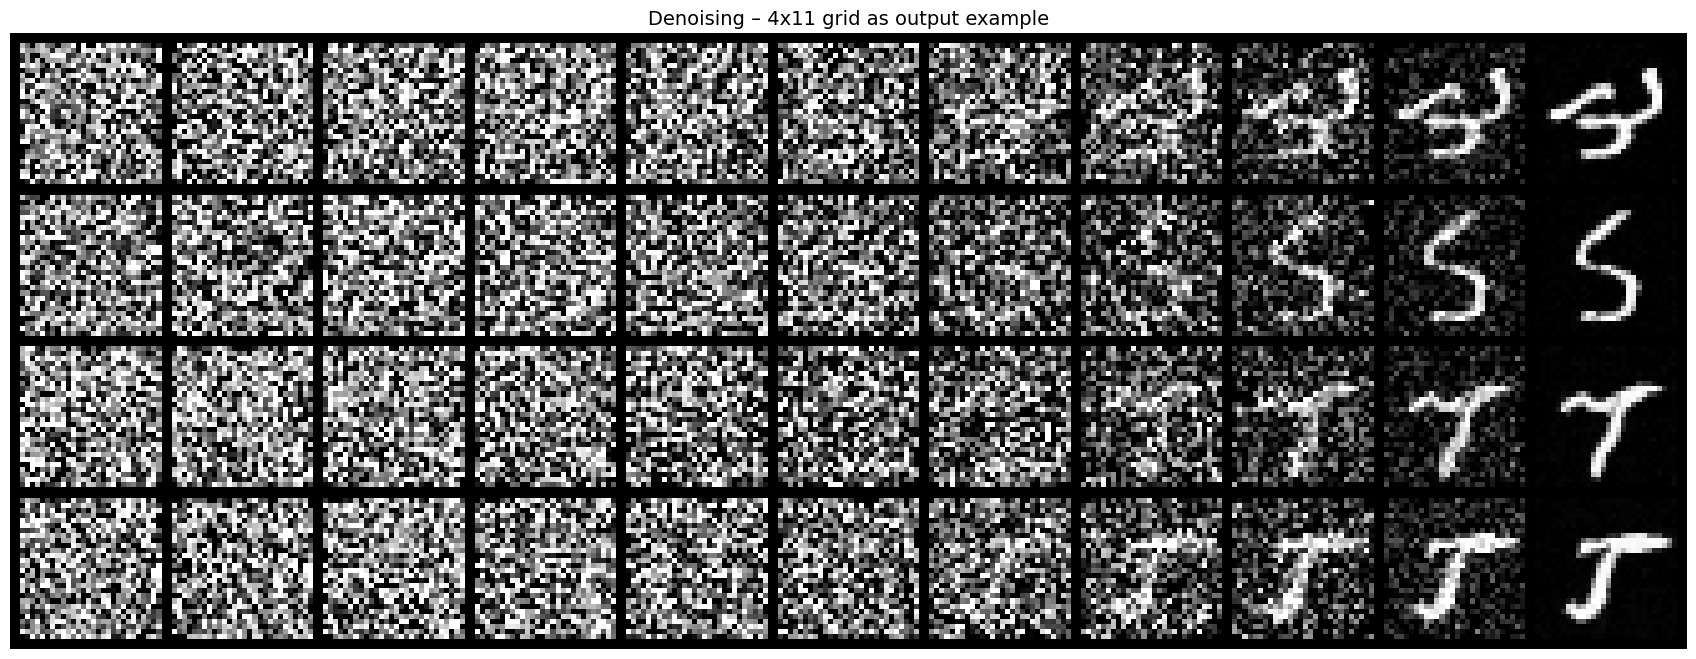

Epoch 11/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11: avg loss = 0.0273


Epoch 12/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12: avg loss = 0.0268


Epoch 13/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13: avg loss = 0.0264


Epoch 14/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14: avg loss = 0.0258


Epoch 15/80:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc3493eef20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc3493eef20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 15: avg loss = 0.0256


Epoch 16/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16: avg loss = 0.0255


Epoch 17/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17: avg loss = 0.0252


Epoch 18/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18: avg loss = 0.0250


Epoch 19/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19: avg loss = 0.0248


Epoch 20/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20: avg loss = 0.0247
Checkpoint saved at vp_sde_ep20.pth


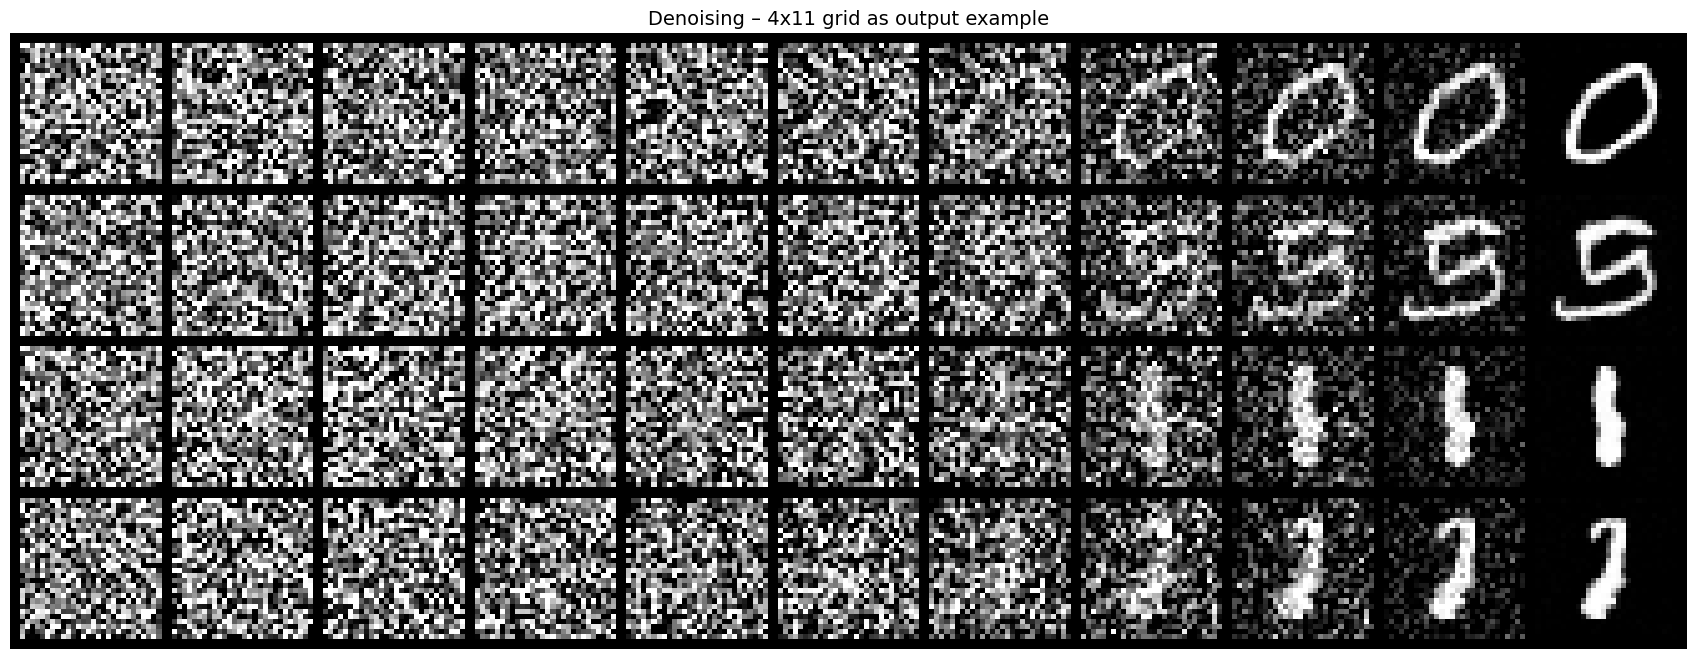

Epoch 21/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21: avg loss = 0.0242


Epoch 22/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22: avg loss = 0.0239


Epoch 23/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23: avg loss = 0.0242


Epoch 24/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24: avg loss = 0.0243


Epoch 25/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25: avg loss = 0.0239


Epoch 26/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26: avg loss = 0.0237


Epoch 27/80:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc3493eef20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc3493eef20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 27: avg loss = 0.0237


Epoch 28/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28: avg loss = 0.0237


Epoch 29/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29: avg loss = 0.0236


Epoch 30/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30: avg loss = 0.0234
Checkpoint saved at vp_sde_ep30.pth


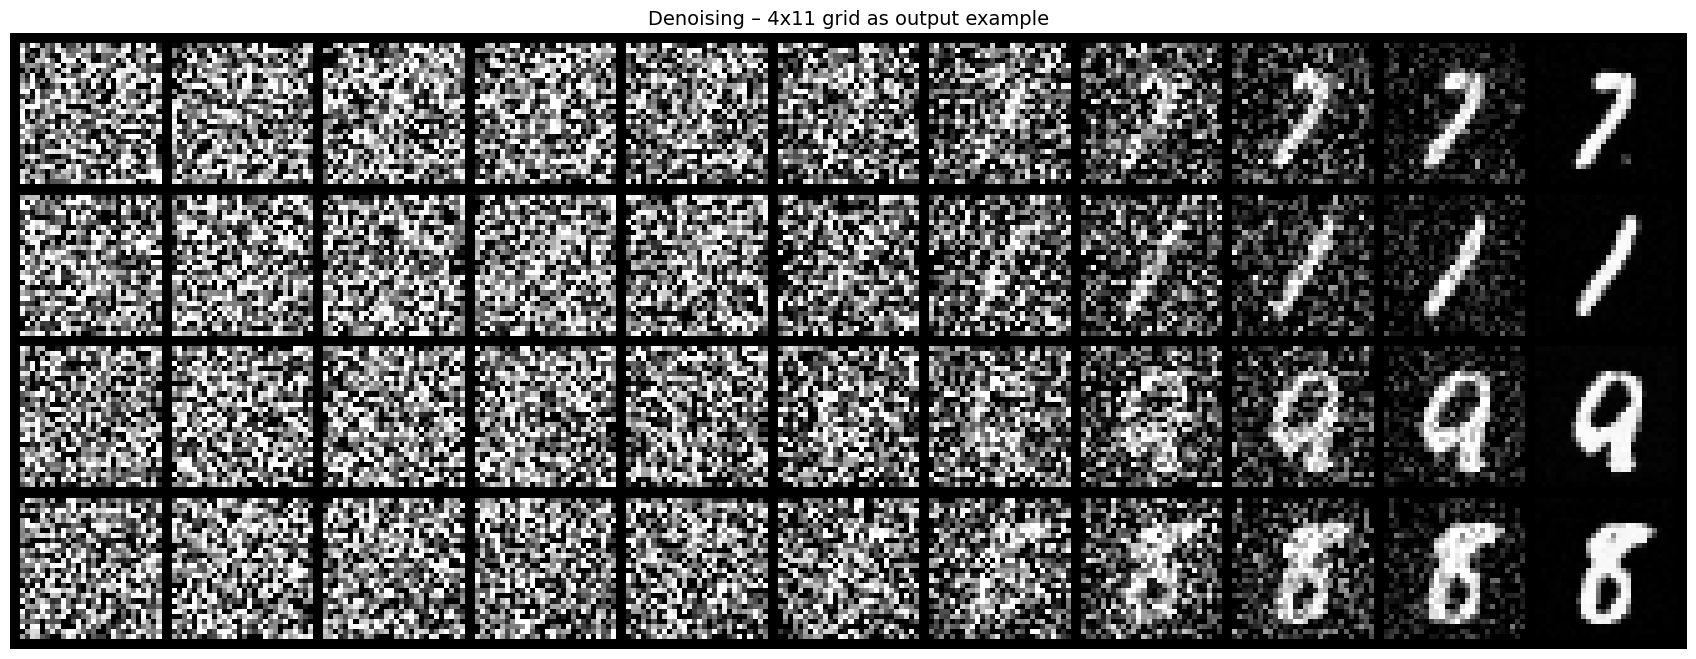

Epoch 31/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31: avg loss = 0.0232


Epoch 32/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 32: avg loss = 0.0234


Epoch 33/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33: avg loss = 0.0231


Epoch 34/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34: avg loss = 0.0234


Epoch 35/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35: avg loss = 0.0233


Epoch 36/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36: avg loss = 0.0232


Epoch 37/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37: avg loss = 0.0227


Epoch 38/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38: avg loss = 0.0229


Epoch 39/80:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc3493eef20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc3493eef20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 39: avg loss = 0.0226


Epoch 40/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40: avg loss = 0.0227
Checkpoint saved at vp_sde_ep40.pth


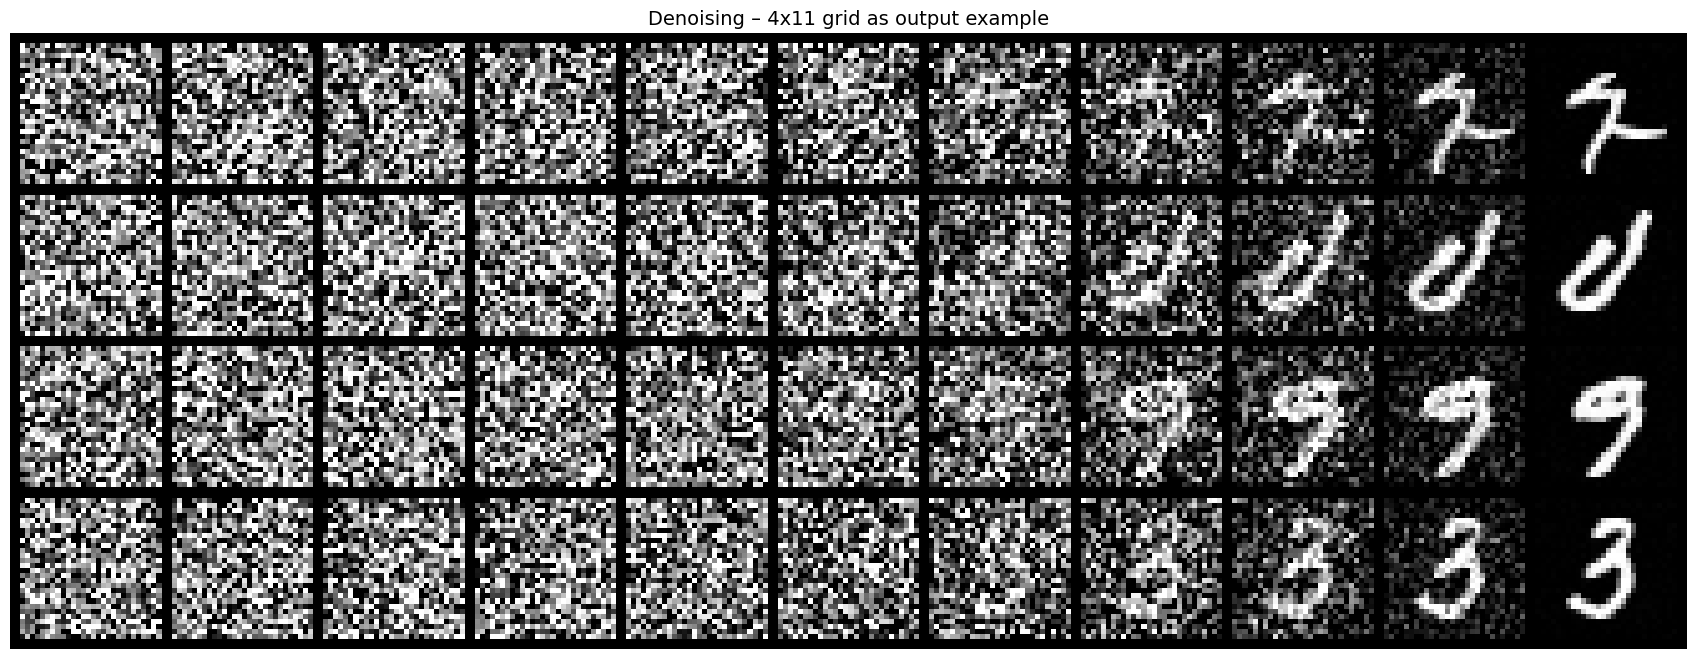

Epoch 41/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41: avg loss = 0.0226


Epoch 42/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42: avg loss = 0.0227


Epoch 43/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43: avg loss = 0.0227


Epoch 44/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44: avg loss = 0.0226


Epoch 45/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45: avg loss = 0.0225


Epoch 46/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46: avg loss = 0.0226


Epoch 47/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47: avg loss = 0.0225


Epoch 48/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 48: avg loss = 0.0222


Epoch 49/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49: avg loss = 0.0226


Epoch 50/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50: avg loss = 0.0225
Checkpoint saved at vp_sde_ep50.pth


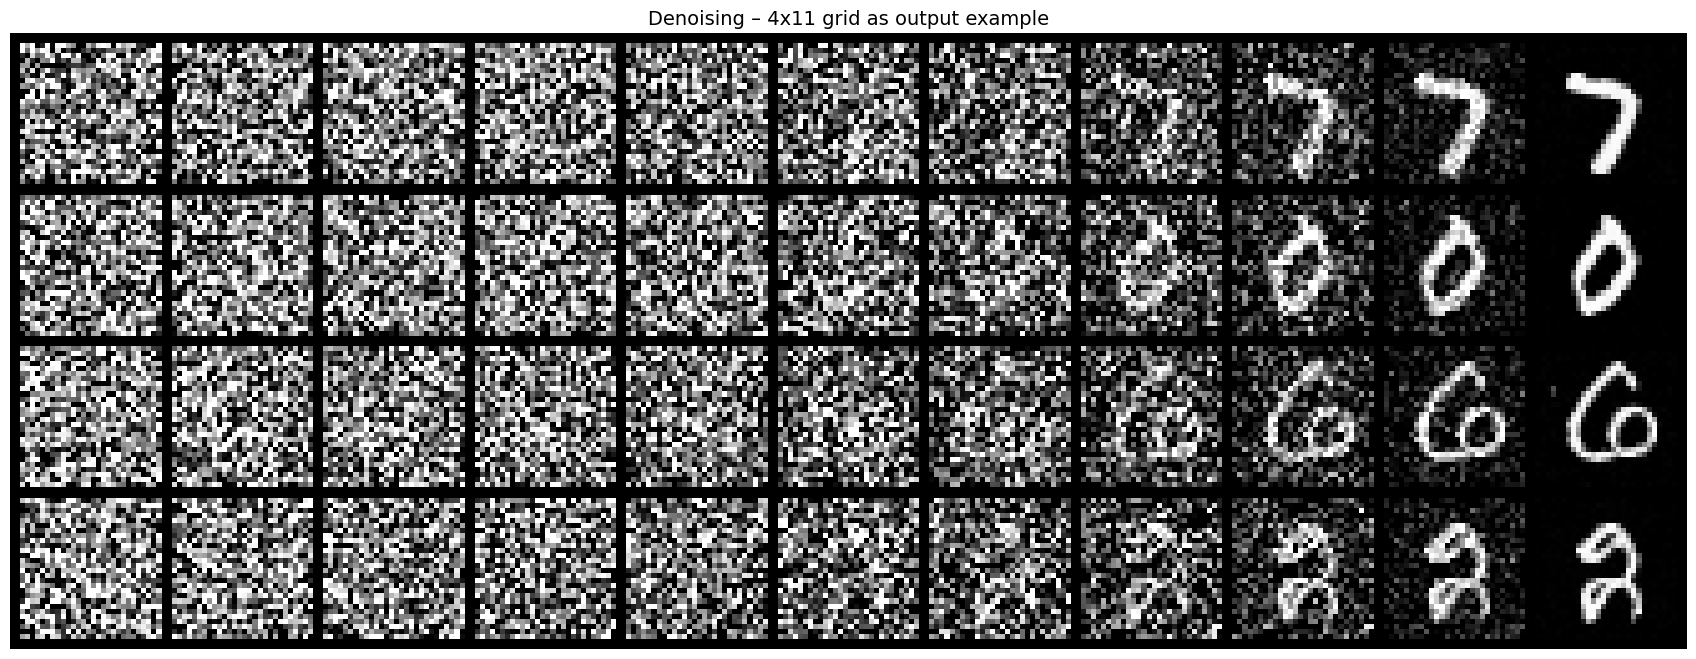

Epoch 51/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 51: avg loss = 0.0224


Epoch 52/80:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc3493eef20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 52: avg loss = 0.0225


Epoch 53/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 53: avg loss = 0.0224


Epoch 54/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 54: avg loss = 0.0220


Epoch 55/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 55: avg loss = 0.0223


Epoch 56/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 56: avg loss = 0.0222


Epoch 57/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57: avg loss = 0.0220


Epoch 58/80:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc3493eef20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
      ^     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc3493eef20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 58: avg loss = 0.0222


Epoch 59/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59: avg loss = 0.0221


Epoch 60/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 60: avg loss = 0.0220
Checkpoint saved at vp_sde_ep60.pth


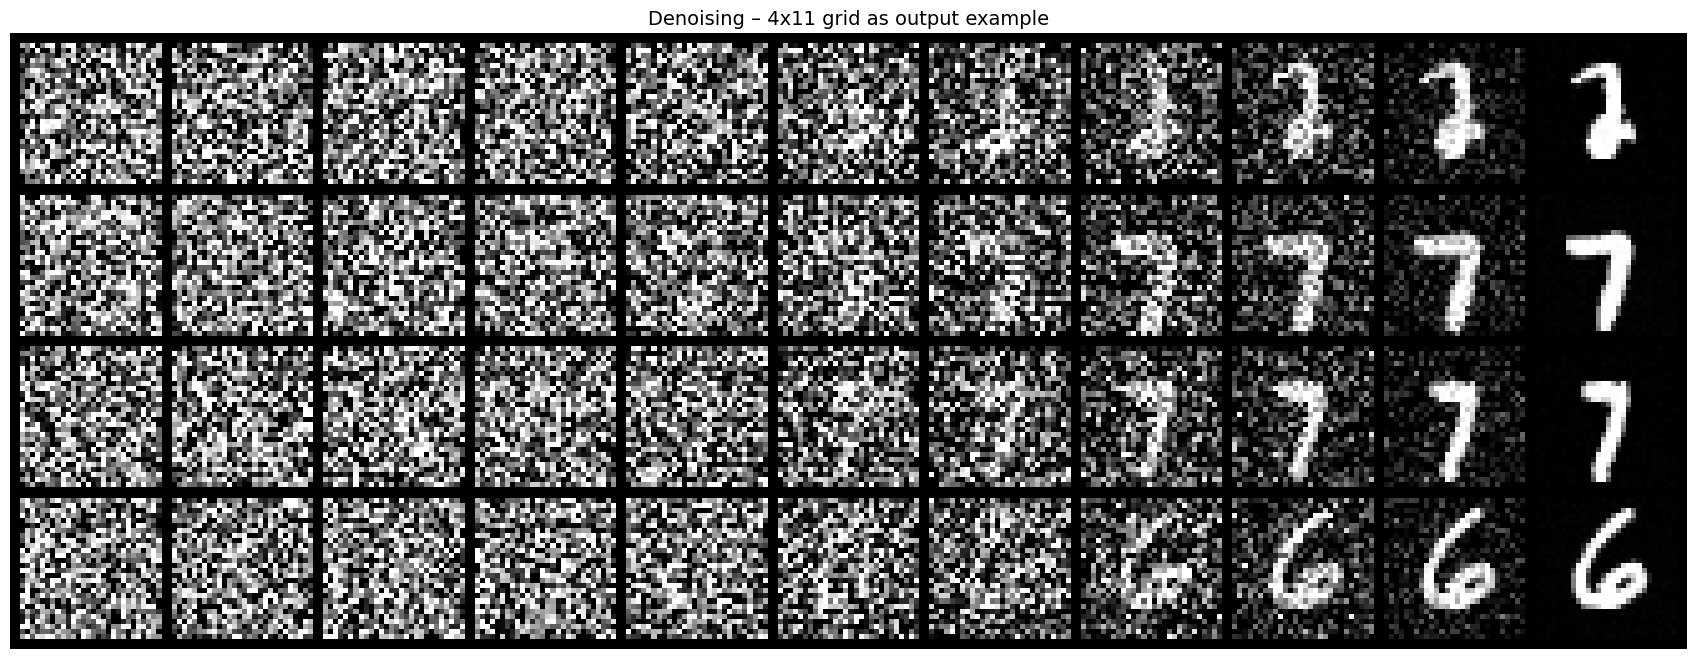

Epoch 61/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 61: avg loss = 0.0219


Epoch 62/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 62: avg loss = 0.0219


Epoch 63/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 63: avg loss = 0.0219


Epoch 64/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 64: avg loss = 0.0220


Epoch 65/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 65: avg loss = 0.0218


Epoch 66/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 66: avg loss = 0.0220


Epoch 67/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 67: avg loss = 0.0220


Epoch 68/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 68: avg loss = 0.0220


Epoch 69/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 69: avg loss = 0.0218


Epoch 70/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 70: avg loss = 0.0217
Checkpoint saved at vp_sde_ep70.pth


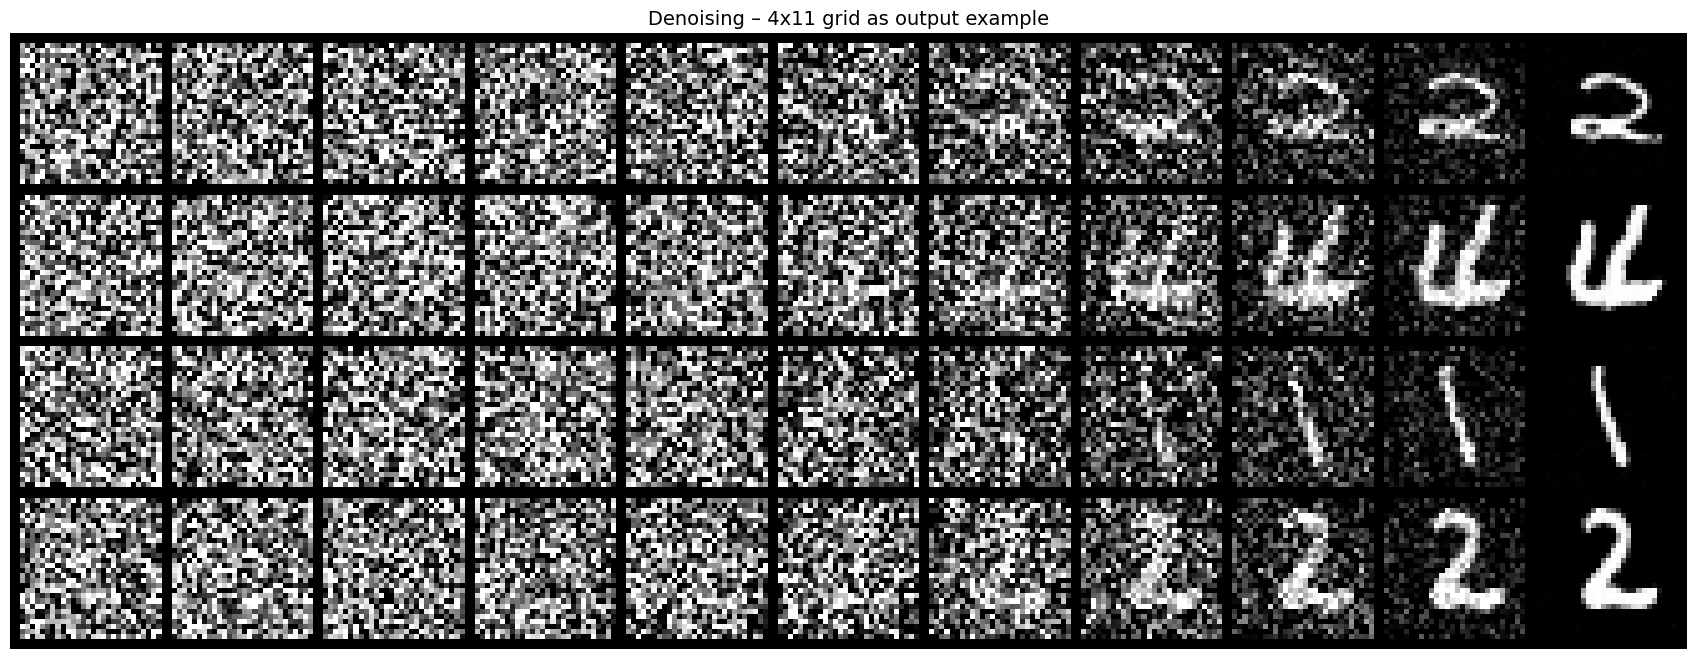

Epoch 71/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 71: avg loss = 0.0216


Epoch 72/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 72: avg loss = 0.0220


Epoch 73/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 73: avg loss = 0.0219


Epoch 74/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 74: avg loss = 0.0217


Epoch 75/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 75: avg loss = 0.0215


Epoch 76/80:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc3493eef20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc3493eef20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 76: avg loss = 0.0219


Epoch 77/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 77: avg loss = 0.0218


Epoch 78/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 78: avg loss = 0.0216


Epoch 79/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 79: avg loss = 0.0215


Epoch 80/80:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 80: avg loss = 0.0216
Checkpoint saved at vp_sde_ep80.pth


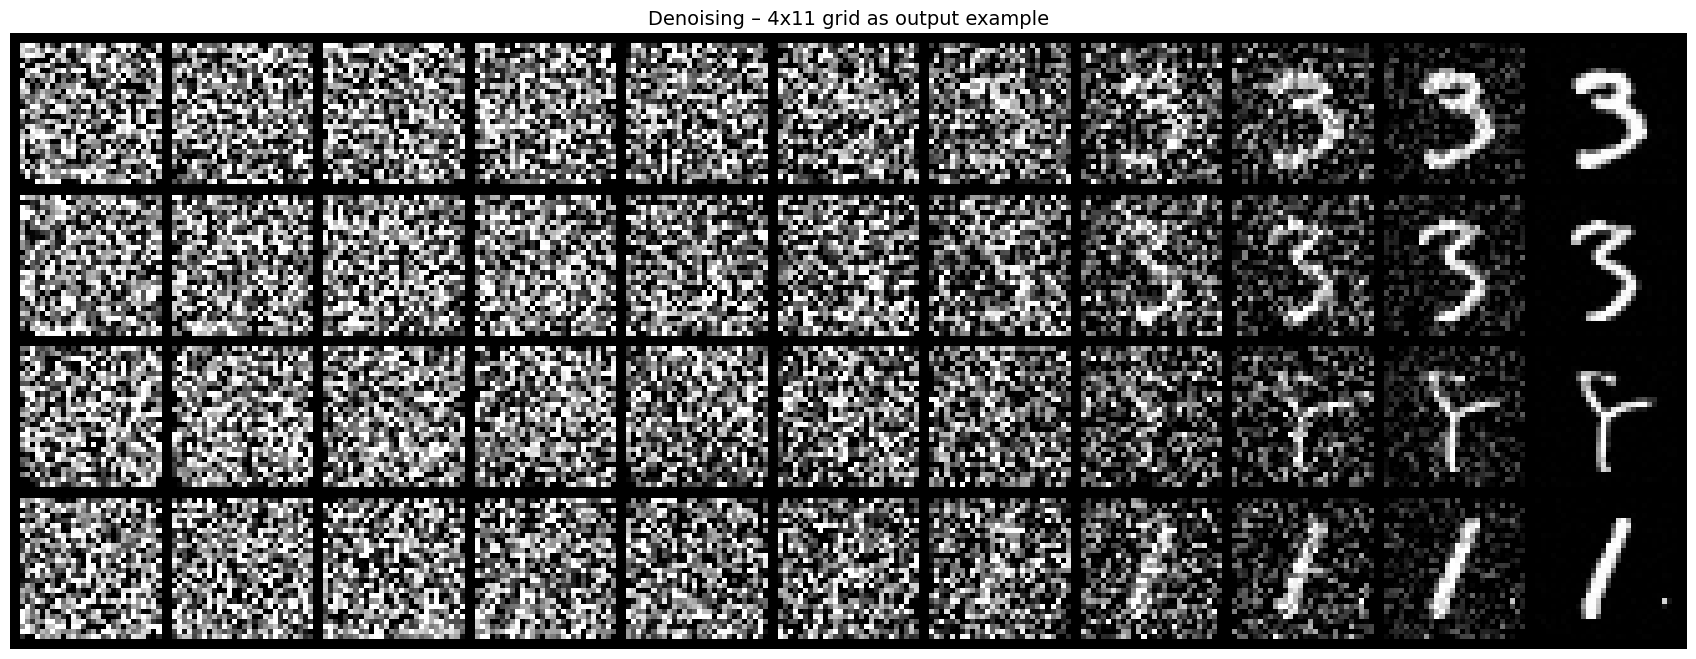

In [7]:
# Main Training Entry Point
if __name__ == "__main__":
    T = 1000
    sde = DDPM_SDE(beta_0=1e-4, beta_1=2e-2, T=T, device=device)
    unet = Unet(base_dim=64, mult_factors=(1,2,4), in_channels=1).to(device)

    train_sde(
        model=unet,
        sde=sde,
        dataloader=loader,
        epochs=80,
        lr=1e-4,
        save_every=10,
        save_prefix="vp_sde"
    )

## Part 4: Conditional Generation

In this part, we will use the model we already trained along with a classifier to generate images that are conditioned on a certain class. Specifically, if we are using MNIST we will generate images of the number 5 and if we are using Fashion MNIST we will generate images of sandals (label 5). Note that the training in this section shouldn't take much time as we are using relatively simple datasets, and we are not training a new score model.

For help in this part, we refer you to the variety of open source implementations of this architecture.

1. Train a CNN classifier on your chosen dataset, noising the images according to the SDE to help the model deal with the noisy images that it will receive in generation. The classifier should reach at least 90% accuracy on the test set without noise (and in reality should reach even 98%+). You can choose to either implement $p_t(y|x)$ or just $p(y|x)$ (time can be an input to the CNN if you wish, not necessary for good enough results).
2. Use the score model from part 3 along with the classifier to sample images using classifier guidance. Sample using the same method of sampling that you chose in part 3, replacing the original score with the new "score". Play with the hyperparameter $\gamma$ (at least 3 different positive values) and briefly explain how different values of $\gamma$ influence the generated images. Generate 64 conditional images for each $\gamma$.
3. For the largest $\gamma$ you choose, run the classifier that you trained on the 64 images you generated. You should reach at least 70% accuracy on these images (meaning the classifier guidance should generate a majority of images that look like the correct class).

Not all images need to be perfect, for example the following output is acceptable for $\gamma=1$.

![image.png](attachment:image.png)

In [8]:
# ================================================================
# NoisyImageDataset: Injects DDPM SDE noise into training images
# ================================================================
class NoisyImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, sde: DDPM_SDE, t_max: float = 0.5, eval_mode: bool = False, force_clean: bool = False):
        self.dataset = dataset
        self.sde = sde
        self.t_max = t_max
        self.eval_mode = eval_mode
        self.force_clean = force_clean

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image_clean, label = self.dataset[index]

        if self.eval_mode or self.force_clean:
            return image_clean, label

        t_scalar = torch.rand(1).item() * self.t_max
        t_tensor = torch.tensor([t_scalar], dtype=torch.float32)

        mean_t, std_t = self.sde.distribution(image_clean.unsqueeze(0), t_tensor)
        noise = torch.randn_like(image_clean)
        image_noisy = (mean_t + std_t * noise).squeeze(0)

        return image_noisy, label



class MNIST_CNN(nn.Module):
    """
    CNN classifier for MNIST/FashionMNIST, designed to be robust to noisy inputs.
    Architecture: 2 conv blocks + 1 hidden FC + softmax.
    """
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # (B, 1, 28, 28) -> (B, 32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)                            # -> (B, 32, 14, 14)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # -> (B, 64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)                            # -> (B, 64, 7, 7)
        )

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)     # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits

from torch.utils.data import ConcatDataset

def train_mnist_classifier(
    model: nn.Module,
    sde,
    dataset,
    device: torch.device,
    epochs: int = 10,
    batch_size: int = 128,
    lr: float = 1e-3,
    t_max: float = 0.5,
    save_path: str = "mnist_cnn.pth",
):
    # Split dataset in half
    n = len(dataset)
    clean_half, noisy_half = torch.utils.data.random_split(dataset, [n // 2, n - n // 2])

    # Create clean and noisy datasets
    clean_ds = NoisyImageDataset(clean_half, sde, t_max=t_max, eval_mode=False, force_clean=True)
    noisy_ds = NoisyImageDataset(noisy_half, sde, t_max=t_max, eval_mode=False, force_clean=False)

    # Combine datasets
    mixed_train_ds = ConcatDataset([clean_ds, noisy_ds])
    train_loader = DataLoader(mixed_train_ds, batch_size=batch_size, shuffle=True)

    # Evaluation on clean images
    test_ds = NoisyImageDataset(dataset, sde, t_max=t_max, eval_mode=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for x, y in tqdm(train_loader, desc=f"[Epoch {epoch}]"):
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = F.cross_entropy(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * x.size(0)
            correct_train += (logits.argmax(dim=1) == y).sum().item()
            total_train += y.size(0)

        train_loss = total_train_loss / total_train
        train_acc = 100.0 * correct_train / total_train

        print(f"Epoch {epoch}/{epochs} — Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")

    # Final test evaluation (clean)
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct_test += (preds == y).sum().item()
            total_test += y.size(0)

    test_acc = 100.0 * correct_test / total_test
    print(f"\n✅ Final Test Accuracy: {test_acc:.2f}%")

    torch.save(model.state_dict(), save_path)
    print(f"✅ Model saved to: {save_path}")




In [9]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define SDE
T = 1000
sde = DDPM_SDE(beta_0=1e-4, beta_1=2e-2, T=T, device=device)

# Load MNIST (rescale to [-1, 1])
transform = transforms.Compose([
    transforms.ToTensor(),             # [0,1]
    lambda x: 2.0 * x - 1.0            # [-1,1]
])

# Download and prepare base dataset
mnist_train = MNIST(root="./data", train=True, download=True, transform=transform)

# Define and train model
model = MNIST_CNN()
train_mnist_classifier(
    model=model,
    sde=sde,
    dataset=mnist_train,
    device=device,
    epochs=20,
    save_path="mnist_cnn_final.pth"
)


[Epoch 1]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/20 — Train Loss: 0.4726 | Train Acc: 84.78%


[Epoch 2]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/20 — Train Loss: 0.2722 | Train Acc: 91.23%


[Epoch 3]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/20 — Train Loss: 0.2443 | Train Acc: 92.08%


[Epoch 4]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/20 — Train Loss: 0.2343 | Train Acc: 92.33%


[Epoch 5]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/20 — Train Loss: 0.2183 | Train Acc: 92.91%


[Epoch 6]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/20 — Train Loss: 0.2111 | Train Acc: 93.09%


[Epoch 7]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/20 — Train Loss: 0.2083 | Train Acc: 93.25%


[Epoch 8]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/20 — Train Loss: 0.2011 | Train Acc: 93.38%


[Epoch 9]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/20 — Train Loss: 0.1940 | Train Acc: 93.72%


[Epoch 10]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/20 — Train Loss: 0.1928 | Train Acc: 93.63%


[Epoch 11]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11/20 — Train Loss: 0.1872 | Train Acc: 93.81%


[Epoch 12]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12/20 — Train Loss: 0.1830 | Train Acc: 94.01%


[Epoch 13]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13/20 — Train Loss: 0.1864 | Train Acc: 93.89%


[Epoch 14]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14/20 — Train Loss: 0.1788 | Train Acc: 94.15%


[Epoch 15]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15/20 — Train Loss: 0.1745 | Train Acc: 94.25%


[Epoch 16]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16/20 — Train Loss: 0.1751 | Train Acc: 94.25%


[Epoch 17]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17/20 — Train Loss: 0.1720 | Train Acc: 94.43%


[Epoch 18]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18/20 — Train Loss: 0.1731 | Train Acc: 94.25%


[Epoch 19]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19/20 — Train Loss: 0.1652 | Train Acc: 94.44%


[Epoch 20]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20/20 — Train Loss: 0.1685 | Train Acc: 94.39%

✅ Final Test Accuracy: 99.47%
✅ Model saved to: mnist_cnn_final.pth


In [16]:
import torch

# Re-initialize the model with the same config used during training
model = Unet(base_dim=64, mult_factors=(1,2,4), in_channels=1).to(device)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load weights
checkpoint_path = "/content/vp_sde_ep60.pth"
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)

print("✅ UNet model loaded successfully from", checkpoint_path)

score_fn = get_score_model_continuous(model, sde)   # s(x,t)

import torch

# Reconstruct the model architecture
classifier = MNIST_CNN()

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = classifier.to(device)

# Load the saved weights
classifier_ckpt_path = "/content/mnist_cnn_final.pth"
classifier.load_state_dict(torch.load(classifier_ckpt_path, map_location=device))

classifier.eval()  # Set to eval mode for inference
print("✅ Classifier loaded successfully from", classifier_ckpt_path)




✅ UNet model loaded successfully from /content/vp_sde_ep60.pth
✅ Classifier loaded successfully from /content/mnist_cnn_final.pth


In [17]:
def grad_logp_clf(x: torch.Tensor, y_target: int = 5):
    """
    Compute ∇ₓ log p(y_target | x) for a batch of inputs x using the classifier.
    """
    x = x.detach().requires_grad_(True)
    logits = classifier(x)
    log_probs = F.log_softmax(logits, dim=1)        # log p(y | x)
    target_logp = log_probs[:, y_target].sum()      # scalar (∑ over batch)
    target_logp.backward()
    return x.grad.detach()                          # ∇ₓ log p(y_target | x) with shape (B, 1, 28, 28)

class GuidedSamplerDDPMSDE(nn.Module):
    """
    Classifier-guided sampler for score-based generative models using DDPM SDE.
    Adds ∇ₓ log p(y | x_t) to the score function with gradient scaling.
    """
    def __init__(self, sde: DDPM_SDE, score_fn, clf, y_target: int = 5):
        super().__init__()
        self.sde = sde
        self.score_fn = score_fn
        self.clf = clf
        self.y_target = y_target
        self.T = sde.T

    @torch.no_grad()
    def forward(self, n_samples: int, gamma: float):
        """
        Perform guided sampling using Euler-Maruyama on the reverse SDE.
        Returns a list of image tensors captured at every 100 steps.
        """
        x = torch.randn(n_samples, 1, 28, 28, device=device)  # Initial Gaussian noise
        dt = 1.0 / self.T
        sqrt_dt = math.sqrt(dt)
        snapshots = []

        for i in reversed(range(self.T + 1)):  # From T → 0
            t_val = i / self.T
            t = torch.full((n_samples,), t_val, device=device)

            # --- Score function from denoiser (∇ₓ log p_t(x)) ---
            score = self.score_fn(x, t)

            # --- Classifier guidance: ∇ₓ log p(y_target | x) ---
            with torch.enable_grad():
                x.requires_grad_(True)
                logits = self.clf(x)
                log_probs = F.log_softmax(logits, dim=1)
                target_logp = log_probs[:, self.y_target].sum()
                grad_logp = torch.autograd.grad(target_logp, x)[0]
            x = x.detach()

            # --- Score modification with gradient scaling ---
            _, std = self.sde.distribution(torch.zeros_like(x), t)  # (B,1,1,1)
            std = std.clamp(min=1e-5)  # Numerical stability
            guided_score = score + gamma * grad_logp / (std ** 2)

            # --- Compute reverse SDE drift and diffusion ---
            drift_forward, diffusion = self.sde.drift_diffusion(x, t)
            beta_t = self.sde.beta(t)[:, None, None, None]
            drift_reverse = drift_forward - beta_t * guided_score

            # --- Store snapshot every 100 steps ---
            if i % 100 == 0:
                snapshots.append(x.cpu())

            # --- Euler-Maruyama update step ---
            if i > 0:
                noise = torch.randn_like(x)
                x = x + (-dt) * drift_reverse + diffusion * sqrt_dt * noise
            else:
                x = x + (-dt) * drift_reverse  # Final step: deterministic

        return snapshots


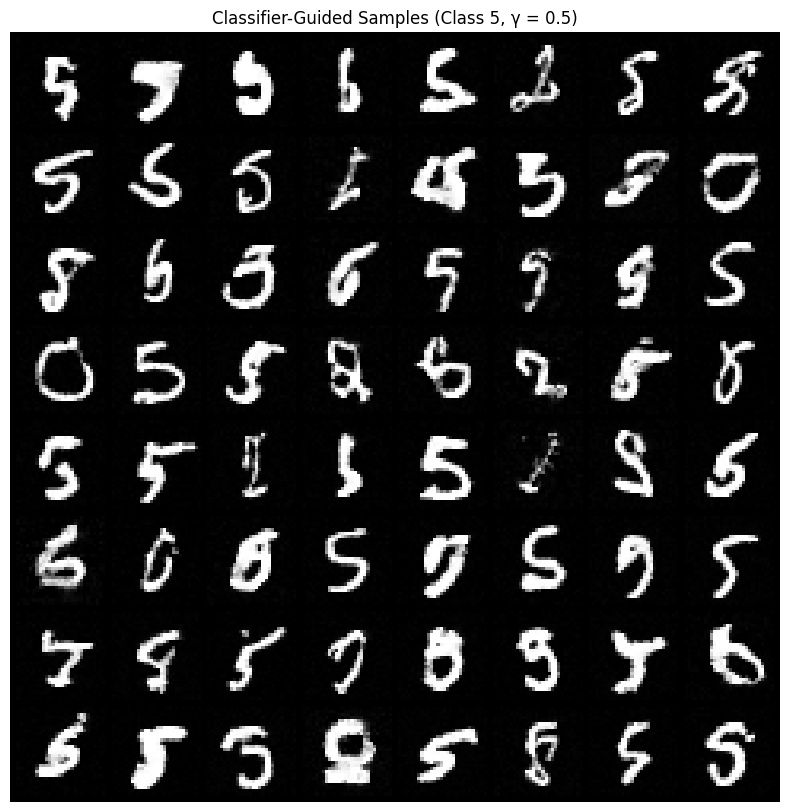

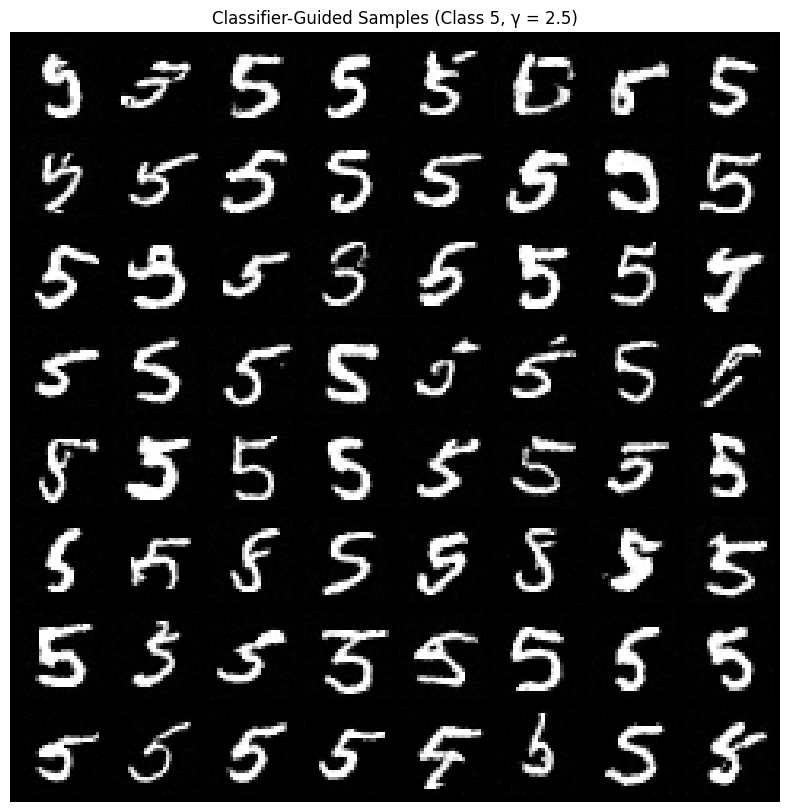

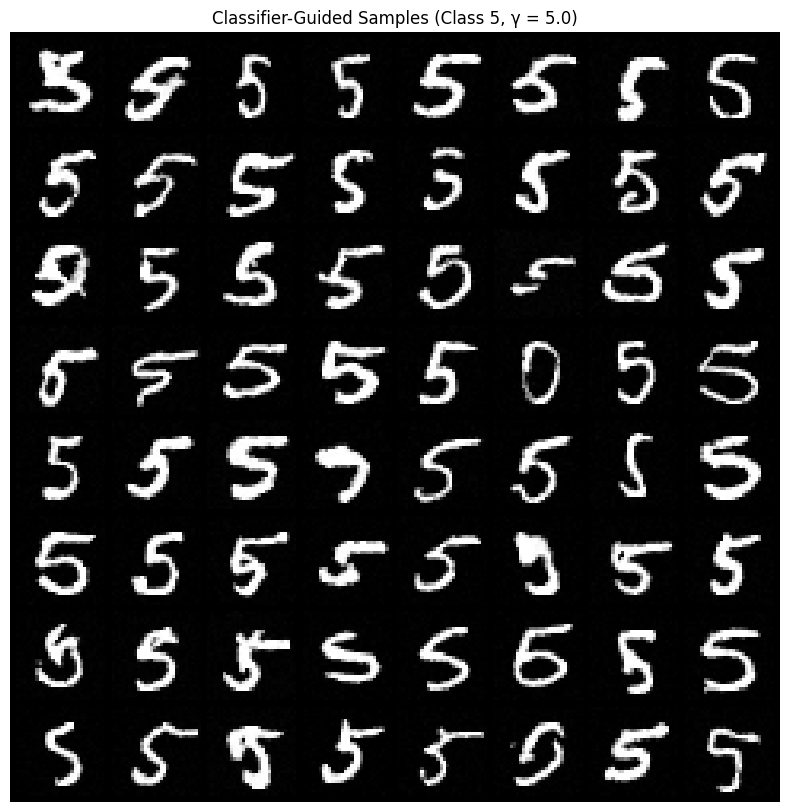

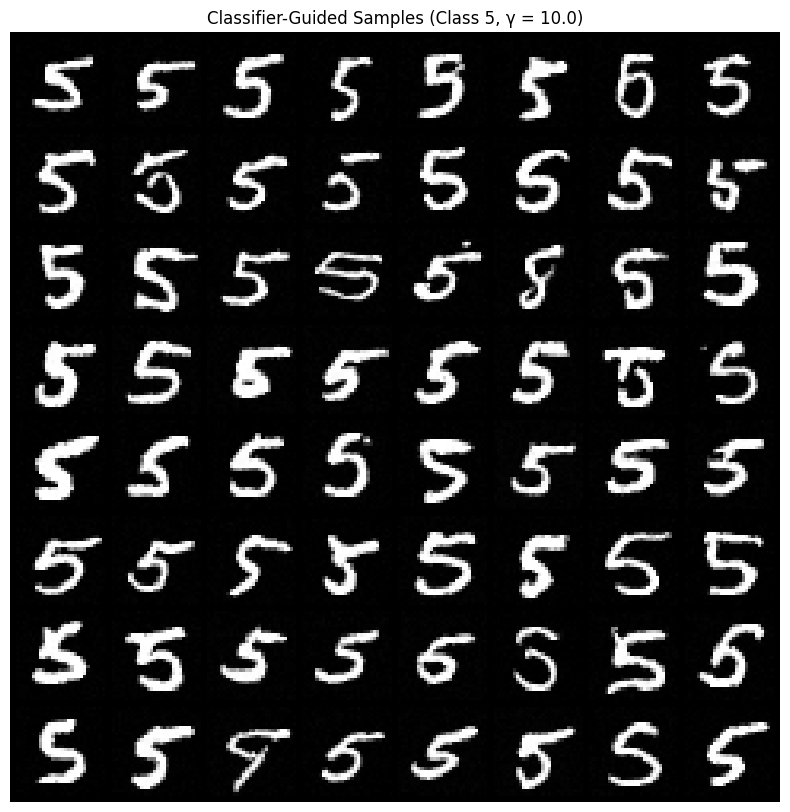

In [18]:
# --- Generate 64 guided samples for each gamma value and visualize

target_class = 5
guided_sampler = GuidedSamplerDDPMSDE(sde, score_fn, classifier, y_target=target_class).to(device)
gamma_values = [0.5, 2.5, 5.0, 10.0]

for gamma in gamma_values:
    # Perform guided sampling (returns list of images across time steps)
    sample_trajectory = guided_sampler(n_samples=64, gamma=gamma)
    generated_images = sample_trajectory[-1]  # Final images at time t=0

    # Create and show grid
    grid = make_grid(generated_images, nrow=8, normalize=True, value_range=(-1, 1))

    plt.figure(figsize=(10, 10))
    plt.title(f"Classifier-Guided Samples (Class {target_class}, γ = {gamma})")
    plt.imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    plt.axis("off")
    plt.show()


In [13]:
import torch
import torch.nn.functional as F

# Generate images using classifier guidance with γ = 10.0
gamma = 10.0
y_target = 5
sampler = GuidedSamplerDDPMSDE(sde, score_fn, classifier, y_target=y_target).to(device)

with torch.no_grad():
    samples = sampler(n_samples=64, gamma=gamma)[-1]  # shape: (64, 1, 28, 28)

# Run classifier on the generated samples
classifier.eval()
samples = samples.to(device)
logits = classifier(samples)
predictions = logits.argmax(dim=1)

# Measure accuracy w.r.t. target class
target_tensor = torch.full((64,), y_target, device=device)
correct = (predictions == target_tensor).sum().item()
accuracy = correct / 64 * 100

print(f"Classifier accuracy on generated samples (γ = {gamma}): {accuracy:.2f}%")


Classifier accuracy on generated samples (γ = 10.0): 100.00%


### **Effect of Gamma (γ) on the Classifier-Guided Sampling**

We generated MNIST digit samples for class **5** using a classifier-guided diffusion model with varying values of γ. Here's how the parameter γ affected the outcome:

---

#### **γ = 0.5**
- **Result**: Many digits are ambiguous or incorrect.
- **Interpretation**: The classifier has very little influence. The score function dominates, so the model generates diverse samples.
- **Conclusion**: Low class fidelity, high visual diversity, poor control.

---

#### **γ = 2.5**
- **Result**: Most digits now resemble 5, with a few imperfections.
- **Interpretation**: The classifier guidance is strong enough to meaningfully shape the generation process toward the desired class.
- **Conclusion**: Good balance between class fidelity and image quality.

---

#### **γ = 5.0**
- **Result**: The vast majority of images are sharp, readable 5s.
- **Interpretation**: Strong classifier influence helps direct the generative process confidently toward class 5.
- **Conclusion**: High class fidelity with good visual consistency but not that much diversity.

---

#### **γ = 10.0**
- **Result**: Almost all samples are recognizable as class 5. Some may appear slightly exaggerated or rigid.
- **Interpretation**: Very strong classifier guidance but with low diversity, a lot of 5 digits appear the same.
- **Conclusion**: Very high class accuracy, slightly reduced diversity in sampling.

---

### **Overall Trend**
As γ increases:
- **Class fidelity increases** — the samples increasingly resemble class 5.
- **Diversity may decrease** — especially at very high γ, where generation is tightly constrained to the classifier’s decision.

